# Autoencoders


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

## Donwload MINST and FMNIST

In [2]:
batch_size = 64

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST and FMNIST datasets
train_mnist = datasets.MNIST('./data', train=True, download=False, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(train_mnist, batch_size=batch_size, shuffle=True)
test_mnist = datasets.MNIST('./data', train=False, download=False, transform=transform)
testloader_mnist = torch.utils.data.DataLoader(test_mnist, batch_size=batch_size, shuffle=True)

train_fmnist = datasets.FashionMNIST('./data', train=True, download=False, transform=transform)
trainloader_fmnist = torch.utils.data.DataLoader(train_fmnist, batch_size=batch_size, shuffle=True)
test_fmnist = datasets.FashionMNIST('./data', train=False, download=False, transform=transform)
testloader_fmnist = torch.utils.data.DataLoader(test_fmnist, batch_size=batch_size, shuffle=True)

In [3]:
dataiter = iter(trainloader_mnist)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


We should then use sigmoid as our last activation function. For pixel values between 0 and 1

#### Creating Validation datasets

In [4]:
import copy


validloader_mnist = copy.deepcopy(trainloader_mnist)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader_mnist.dataset.data = trainloader_mnist.dataset.data[:45000,:,:]
trainloader_mnist.dataset.targets = trainloader_mnist.dataset.targets[:45000]

#And the rest for validation
validloader_mnist.dataset.data = validloader_mnist.dataset.data[45000:,:,:]
validloader_mnist.dataset.targets = validloader_mnist.dataset.targets[45000:]


validloader_fmnist = copy.deepcopy(trainloader_fmnist)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader_fmnist.dataset.data = trainloader_fmnist.dataset.data[:45000,:,:]
trainloader_fmnist.dataset.targets = trainloader_fmnist.dataset.targets[:45000]

#And the rest for validation
validloader_fmnist.dataset.data = validloader_fmnist.dataset.data[45000:,:,:]
validloader_fmnist.dataset.targets = validloader_fmnist.dataset.targets[45000:]

##### Tensor to GPU or CPU function

In [7]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

## Autoencoder with 3 layers at both Encoder and Decoder (Non-Regularized)

#### Training without Regularization:

Firstly, before training our autoencoder with a regularization technique it is a good idea to see the performance of one without it. This way we can use the best technique to prevent overfitting. The most commonly deployed technique to prevent overfitting is the Dropout technique. This technique assigns a probability p to deactivate each node in the layer. That is to say that the hyper-parameter p, needs to be set at a value that is best depending on our results of overfitting. 

In the following implementation, an indication of overfitting is that we should see that the validation set obtains a much worse performance than the training set.

Creating the model:

In [5]:
class Autoencoder3Layers(nn.Module):

    def __init__(self, input_dim, hidden1, proj_dim, epochs=30, lr =0.01, p = 0.1):

        super(Autoencoder3Layers, self).__init__()
        self.lr = lr
        self.epochs = epochs
        self.dropout = nn.Dropout(p=p)
        self.criterion = nn.MSELoss()
        
        # self.optim = optim.SGD(self.parameters(), lr=0.01, weight_decay=0.001)
        self.loss_during_training = []
        self.loss_during_validation = []
        self.loss_during_testing = []
        
        self.encoder = nn.Sequential(
            # layer 1
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            # layer 2
            nn.Linear(hidden1, hidden1//2),
            nn.ReLU(),
            # layer 3
            nn.Linear(hidden1//2, proj_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            # layer 3
            nn.Linear(proj_dim, hidden1//2),
            nn.ReLU(),
            # layer 2
            nn.Linear(hidden1//2, hidden1),
            nn.ReLU(),
            # layer 1
            nn.Linear(hidden1, input_dim),
            nn.Sigmoid()
        )
        self.optim = optim.Adam(self.parameters(), lr=self.lr)
        
    # do the training with this (encode then decode...)
    def forward(self, x):
        # x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def train_autoencoder(self,trainloader,valloader):

        self.train()
        # Optimization Loop
        for e in range(int(self.epochs)):

            running_loss = 0.
            running_loss_val=0.
            
            for images,_ in trainloader:              
                self.optim.zero_grad()  
                flattened_images = images.reshape(-1, 28*28)
                out = self.forward(flattened_images)
                loss = self.criterion(out,flattened_images)
                loss.backward()
                self.optim.step()
                running_loss += loss.item()
            self.loss_during_training.append(running_loss/len(trainloader))
            if(e % 1 == 0): # Every 10 epochs
                print("Training loss after (%d) epochs: ---------------   (%f)" 
                      %(e,self.loss_during_training[-1]))
            # Validation is without training mode
            # We also must remove the optimization and backwards propagation step
            # make a different running loss.
            # self.train(mode=False)
            with torch.no_grad():
                self.eval()
                for images,_ in valloader:              

                    flattened_images = images.reshape(-1, 28*28)
                    out = self.forward(flattened_images)
                    loss = self.criterion(out,flattened_images)
                    running_loss_val += loss.item()               
                self.loss_during_validation.append(running_loss_val/len(valloader))
            self.train(mode=True)
            if(e % 1 == 0): # Every 10 epochs

                print("Validation loss after (%d) epochs: --------------- (%f)" 
                      %(e,self.loss_during_validation[-1]))
                
    def test_autoencoder(self, testloader):
        self.eval()
        running_loss_test = 0.

        with torch.no_grad():
            for images, _ in testloader:
                flattened_images = images.reshape(-1, 28 * 28)
                out = self.forward(flattened_images)
                loss = self.criterion(out, flattened_images)
                running_loss_test += loss.item()

            self.loss_during_testing.append(running_loss_test / len(testloader))

        print("Testing loss: (%f)" % (self.loss_during_testing[-1]))



Training and testing with the MNIST data set for 20 epochs.

In [6]:
proj_dim_list = [15, 30, 50, 100]

training_loss_all = []
validation_loss_all = []
test_loss_all = []
epochs=10
epoch_list = np.arange(0,10)

for i in range(0, len(proj_dim_list)):

    print("\nProjected dimension = {} ---------------------------------------------\n".format(proj_dim_list[i]) )
    autoencoder_3l_MNIST = Autoencoder3Layers(input_dim = 28*28, hidden1 = 256, proj_dim = proj_dim_list[i], epochs = 20, lr=0.01)

    Autoencoder3Layers.train_autoencoder(autoencoder_3l_MNIST,trainloader_mnist, validloader_mnist)

    training_loss_all.append(autoencoder_3l_MNIST.loss_during_training)

    validation_loss_all.append(autoencoder_3l_MNIST.loss_during_validation)

    Autoencoder3Layers.test_autoencoder(autoencoder_3l_MNIST, testloader_mnist)
    
    test_loss_all.append(autoencoder_3l_MNIST.loss_during_testing)


Projected dimension = 15 ---------------------------------------------

Training loss after (0) epochs: ---------------   (0.040147)
Validation loss after (0) epochs: --------------- (0.031934)
Training loss after (1) epochs: ---------------   (0.027160)
Validation loss after (1) epochs: --------------- (0.025703)
Training loss after (2) epochs: ---------------   (0.024945)
Validation loss after (2) epochs: --------------- (0.025124)
Training loss after (3) epochs: ---------------   (0.024095)
Validation loss after (3) epochs: --------------- (0.025474)
Training loss after (4) epochs: ---------------   (0.023711)
Validation loss after (4) epochs: --------------- (0.023936)
Training loss after (5) epochs: ---------------   (0.023386)
Validation loss after (5) epochs: --------------- (0.026892)
Training loss after (6) epochs: ---------------   (0.023349)
Validation loss after (6) epochs: --------------- (0.023564)
Training loss after (7) epochs: ---------------   (0.023063)
Validation l

#### Doing the same but for FMNIST

In [7]:
proj_dim_list = [15, 30, 50, 100]

training_loss_all_fmnist = []
validation_loss_all_fmnist = []
test_loss_all_fmnist = []
epochs=10
epoch_list = np.arange(0,10)

for i in range(0, len(proj_dim_list)):

    print("\nProjected dimension = {} ---------------------------------------------\n".format(proj_dim_list[i]) )
    autoencoder_3l_FMNIST = Autoencoder3Layers(input_dim = 28*28, hidden1 = 256, proj_dim = proj_dim_list[i], epochs = 20, lr=0.01)

    Autoencoder3Layers.train_autoencoder(autoencoder_3l_FMNIST,trainloader_fmnist, validloader_fmnist)

    training_loss_all_fmnist.append(autoencoder_3l_FMNIST.loss_during_training)

    validation_loss_all_fmnist.append(autoencoder_3l_FMNIST.loss_during_validation)

    Autoencoder3Layers.test_autoencoder(autoencoder_3l_FMNIST, testloader_fmnist)
    
    test_loss_all_fmnist.append(autoencoder_3l_FMNIST.loss_during_testing)


Projected dimension = 15 ---------------------------------------------

Training loss after (0) epochs: ---------------   (0.030204)
Validation loss after (0) epochs: --------------- (0.023481)
Training loss after (1) epochs: ---------------   (0.021145)
Validation loss after (1) epochs: --------------- (0.022709)
Training loss after (2) epochs: ---------------   (0.019944)
Validation loss after (2) epochs: --------------- (0.020364)
Training loss after (3) epochs: ---------------   (0.019222)
Validation loss after (3) epochs: --------------- (0.019076)
Training loss after (4) epochs: ---------------   (0.018850)
Validation loss after (4) epochs: --------------- (0.019587)
Training loss after (5) epochs: ---------------   (0.018619)
Validation loss after (5) epochs: --------------- (0.019390)
Training loss after (6) epochs: ---------------   (0.018624)
Validation loss after (6) epochs: --------------- (0.019360)
Training loss after (7) epochs: ---------------   (0.018338)
Validation l

In [39]:
def find_best(all_test_list):
    test_list = [each[-1] for each in all_test_list]

    index_test_list = test_list.index(min(test_list))
    return index_test_list

best_results_FMNIST = proj_dim_list[find_best(validation_loss_all_fmnist)]

best_results_MNIST = proj_dim_list[find_best(validation_loss_all)]


print("Best Naive 3 layer Model for the MNIST data is for projected dimensions: {}".format(best_results_MNIST))
print("Best Naive 3 layer Model for the FMNIST data is for projected dimensions: {}".format(best_results_FMNIST))

Best Naive 3 layer Model for the MNIST data is for projected dimensions: 100
Best Naive 3 layer Model for the FMNIST data is for projected dimensions: 50


Summarizing the results.

In [44]:
# Validation loss:
print("-------------------- 3 Layer Results Summary -------------------------\n")

print("MNIST Results -----------------------\n")

for i in range(0,len(proj_dim_list)):
    
    print('Projected dimension: ({}) validation loss --> {}'.format(proj_dim_list[i], test_loss_all[i][-1]))


print("\nBest resulting MNIST projection dimension {}\n".format(best_results_MNIST))

print('FMNIST Results -----------------------\n')

for i in range(0,len(proj_dim_list)):
    
    print('Projected dimension: ({}) validation loss --> {}'.format(proj_dim_list[i], test_loss_all_fmnist[i][-1]))

print("\nBest resulting FMNIST projection dimension {}".format(best_results_FMNIST))

print("\n----------------------------------------------------------------------\n")


-------------------- 3 Layer Results Summary -------------------------

MNIST Results -----------------------

Projected dimension: (15) validation loss --> 0.023673441213597157
Projected dimension: (30) validation loss --> 0.01865193797097464
Projected dimension: (50) validation loss --> 0.026285382746985764
Projected dimension: (100) validation loss --> 0.01711923973694159

Best resulting MNIST projection dimension 100

FMNIST Results -----------------------

Projected dimension: (15) validation loss --> 0.022186334203382965
Projected dimension: (30) validation loss --> 0.017921442314270574
Projected dimension: (50) validation loss --> 0.016505821097855734
Projected dimension: (100) validation loss --> 0.01722939684393869

Best resulting FMNIST projection dimension 50

----------------------------------------------------------------------



#### MNIST / FMNIST 3 layer results as a function of epochs

3 layer model for MNIST dataset. Validation and training results as a function of epochs.

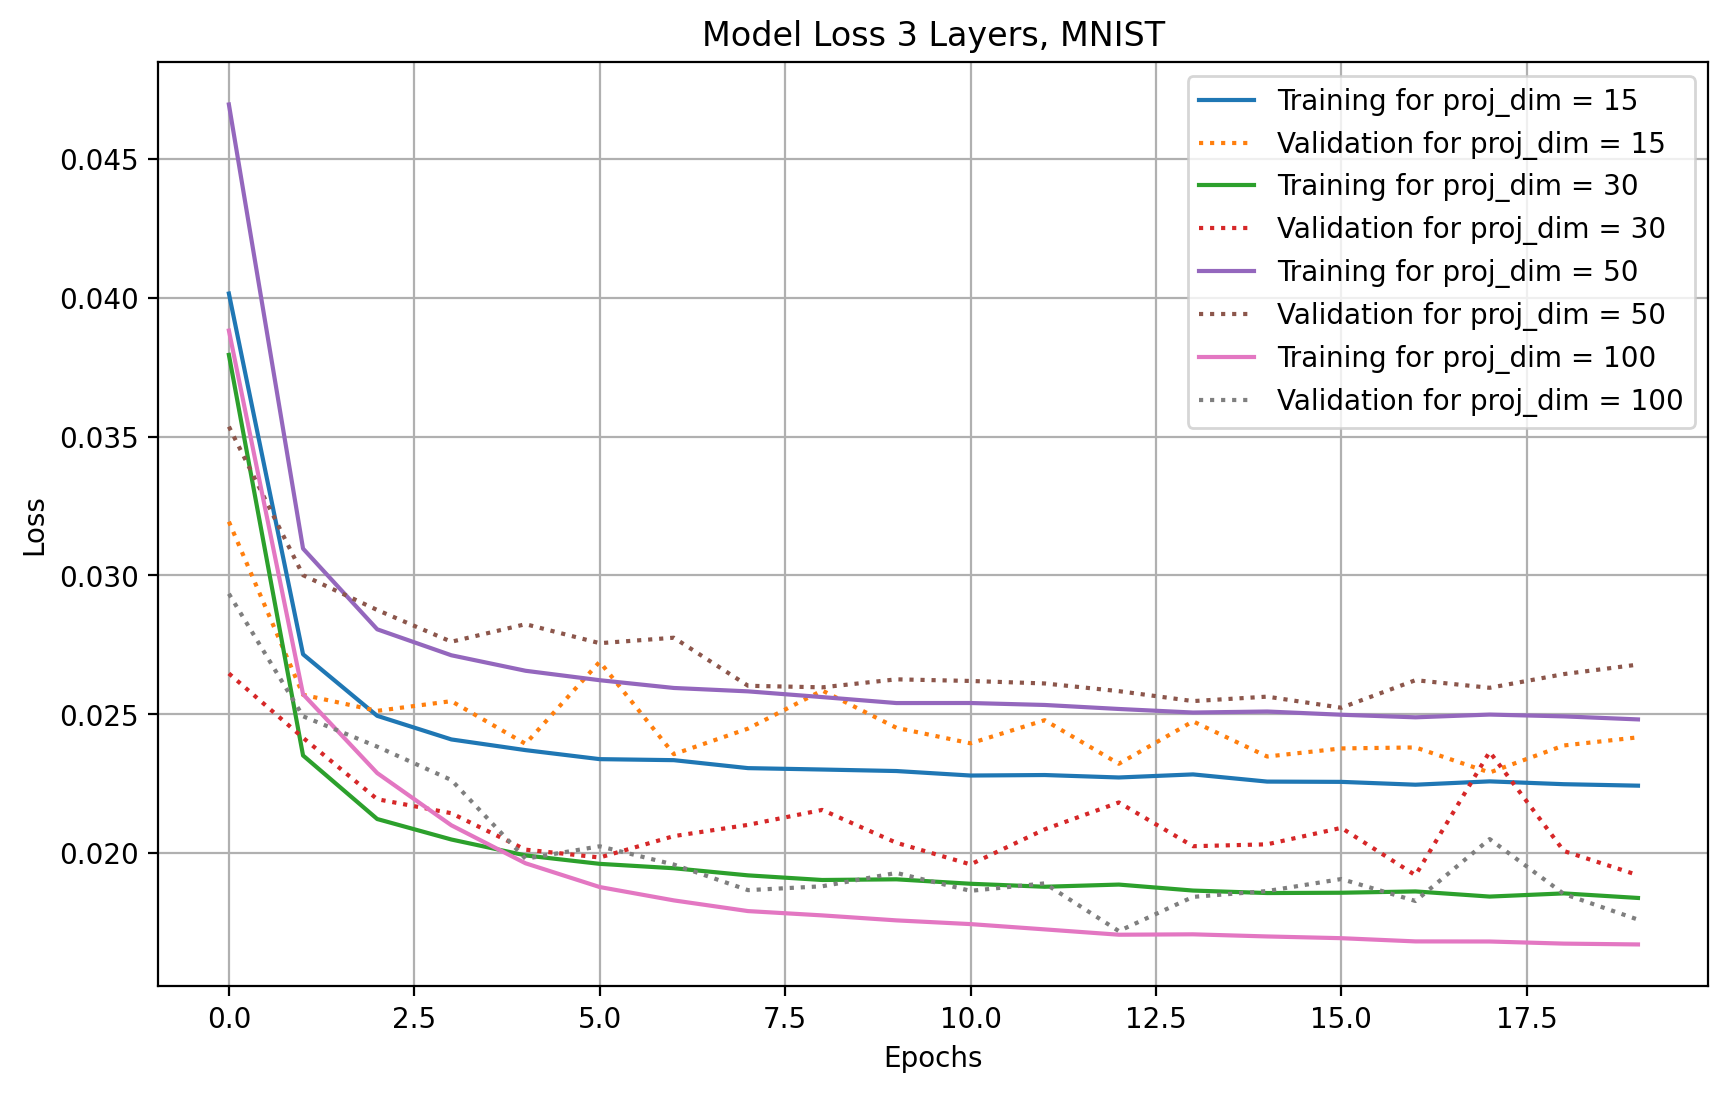

In [11]:
# MNIST
epoch_list = np.arange(0,20)
fig = plt.figure(figsize=(10, 6))
for i in range(0,len(proj_dim_list)):

    label_training = str("Training for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, training_loss_all[i],label = label_training)

    label_validation = str("Validation for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, validation_loss_all[i], linestyle='dotted',label = label_validation)


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Model Loss 3 Layers, MNIST')
plt.legend()
plt.show()

3 layer model for FMNIST dataset. Validation and training results as a function of epochs.

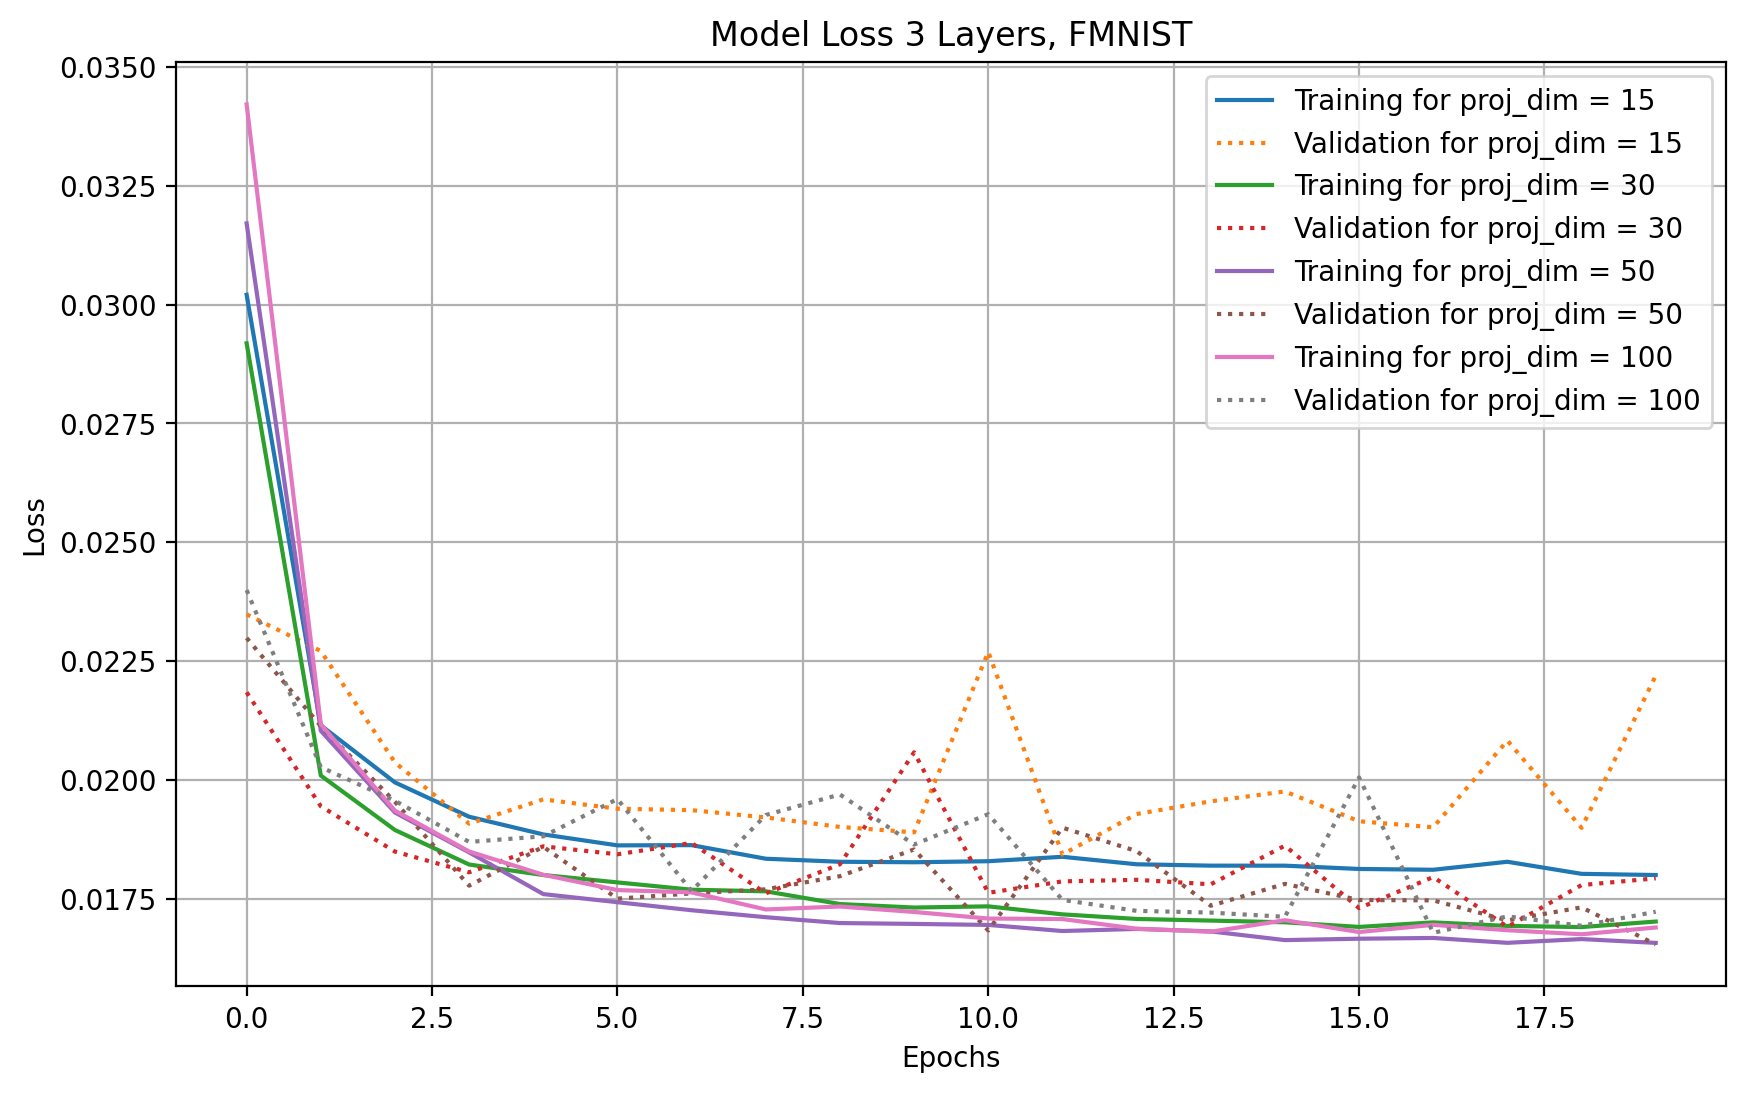

In [10]:
#FMNIST
epoch_list = np.arange(0,20)
fig = plt.figure(figsize=(10, 6))
for i in range(0,len(proj_dim_list)):

    label_training = str("Training for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, training_loss_all_fmnist[i],label = label_training)

    label_validation = str("Validation for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, validation_loss_all_fmnist[i], linestyle='dotted',label = label_validation)


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Model Loss 3 Layers, FMNIST')
plt.legend()
plt.show()

### Autoencoder with 5 Layers without Regularization


In this part, the number of hidden dimensions was increased from 256 to 512. The following code shows the Auto-encoder general model used without regularization, as well as the training and validation method used.

In [13]:
class Autoencoder5Layers(nn.Module):

    def __init__(self, input_dim, hidden1, proj_dim, epochs=20, lr =0.01, p = 0.1):

        super(Autoencoder5Layers, self).__init__()


        self.lr = lr
        self.epochs = epochs
        self.dropout = nn.Dropout(p=p)
        self.criterion = nn.MSELoss()

        
        # self.optim = optim.SGD(self.parameters(), lr=0.01, weight_decay=0.001)
        self.loss_during_training = []
        self.loss_during_validation = []
        self.loss_during_testing = []
        
        self.encoder = nn.Sequential(
            # layer 1
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            # layer 2
            nn.Linear(hidden1, hidden1//2),
            nn.ReLU(),
            # layer 3
            nn.Linear(hidden1//2, hidden1//4),
            nn.ReLU(),
            # layer 4
            nn.Linear(hidden1//4, hidden1//6),
            nn.ReLU(),
            # layer 5
            nn.Linear(hidden1//6, proj_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            # layer 5
            nn.Linear(proj_dim, hidden1//6),
            nn.ReLU(),

            # layer 4
            nn.Linear(hidden1//6, hidden1//4),
            nn.ReLU(),

            # layer 3
            nn.Linear(hidden1//4, hidden1//2),
            nn.ReLU(),

            # layer 2
            nn.Linear(hidden1//2, hidden1),
            nn.ReLU(),
           
            # layer 1

            nn.Linear(hidden1, input_dim),
            nn.Sigmoid()
        )

        self.optim = optim.Adam(self.parameters(), lr=self.lr)
        
    # do the training with this (encode then decode...)
    def forward(self, x):
        # x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
    def train_autoencoder(self,trainloader,valloader):

        self.train()


        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            
            running_loss = 0.
            running_loss_val=0.
            
            for images, nothing in trainloader:              
                
                self.optim.zero_grad()  
            
                flattened_images = images.reshape(-1, 28*28)

                out = self.forward(flattened_images)

                loss = self.criterion(out,flattened_images)

                loss.backward()

                self.optim.step()

                running_loss += loss.item()
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after (%d) epochs: ---------------   (%f)" 
                      %(e,self.loss_during_training[-1]))


            # Validation is without training mode
            # We also must remove the optimization and backwards propagation step
            # make a different running loss.
            # self.train(mode=False)

            with torch.no_grad():

                self.eval()
                for images, nothing in valloader:              
                    
                    # self.optim.zero_grad()  
                
                    flattened_images = images.reshape(-1, 28*28)

                    out = self.forward(flattened_images)


                    loss = self.criterion(out,flattened_images)

                    running_loss_val += loss.item()
                
                self.loss_during_validation.append(running_loss_val/len(valloader))

            self.train(mode=True)

            if(e % 1 == 0): # Every 10 epochs

                print("Validation loss after (%d) epochs: --------------- (%f)" 
                      %(e,self.loss_during_validation[-1]))
                

    def test_performance(self, testloader):
        self.eval()
        running_loss_test = 0.

        with torch.no_grad():
            for images, _ in testloader:

                flattened_images = images.reshape(-1, 28 * 28)

                out = self.forward(flattened_images)

                loss = self.criterion(out, flattened_images)
                
                running_loss_test += loss.item()

            self.loss_during_testing.append(running_loss_test / len(testloader))

        print("Testing loss: (%f)" % (self.loss_during_testing[-1]))


Training and Testing the MNIST data set.

In [14]:
# FMNIST 5 LAYERS NAIVE
proj_dim_list = [15, 30, 50, 100]

# 5 layers = l5
l5_training_loss_all = []
l5_validation_loss_all = []
l5_test_loss_all= []
epochs=10
epoch_list = np.arange(0,20)

for i in range(0, len(proj_dim_list)):

    print("\nProjected dimension = {} ---------------------------------------------\n".format(proj_dim_list[i]) )
    autoencoder_5L_MNIST = Autoencoder5Layers(input_dim = 28*28, hidden1 = 512, proj_dim = proj_dim_list[i], epochs = 20, lr=0.01)

    Autoencoder5Layers.train_autoencoder(autoencoder_5L_MNIST,trainloader_mnist, validloader_mnist)

    l5_training_loss_all.append(autoencoder_5L_MNIST.loss_during_training)

    l5_validation_loss_all.append(autoencoder_5L_MNIST.loss_during_validation)

    autoencoder_5L_MNIST.test_performance(testloader=testloader_mnist)
    l5_test_loss_all.append(autoencoder_5L_MNIST.loss_during_testing)

print("\n***All done***")


Projected dimension = 15 ---------------------------------------------

Training loss after (0) epochs: ---------------   (0.056833)
Validation loss after (0) epochs: --------------- (0.048436)
Training loss after (1) epochs: ---------------   (0.045203)
Validation loss after (1) epochs: --------------- (0.044466)
Training loss after (2) epochs: ---------------   (0.042885)
Validation loss after (2) epochs: --------------- (0.041721)
Training loss after (3) epochs: ---------------   (0.042037)
Validation loss after (3) epochs: --------------- (0.042478)
Training loss after (4) epochs: ---------------   (0.044616)
Validation loss after (4) epochs: --------------- (0.045194)
Training loss after (5) epochs: ---------------   (0.042168)
Validation loss after (5) epochs: --------------- (0.042201)
Training loss after (6) epochs: ---------------   (0.041616)
Validation loss after (6) epochs: --------------- (0.046932)
Training loss after (7) epochs: ---------------   (0.042157)
Validation l

Doing the same but for the FMNIST data set.

In [15]:
# FMNIST 5 LAYERS NAIVE
proj_dim_list = [15, 30, 50, 100]

# 5 layers = l5
Fl5_training_loss_all = []
Fl5_validation_loss_all = []
Fl5_test_loss_all= []
epochs=10
epoch_list = np.arange(0,20)

for i in range(0, len(proj_dim_list)):

    print("\nProjected dimension = {} ---------------------------------------------\n".format(proj_dim_list[i]) )
    autoencoder_5L_FMNIST = Autoencoder5Layers(input_dim = 28*28, hidden1 = 512, proj_dim = proj_dim_list[i], epochs = 20, lr=0.01)

    Autoencoder5Layers.train_autoencoder(autoencoder_5L_FMNIST,trainloader_fmnist, validloader_fmnist)

    Fl5_training_loss_all.append(autoencoder_5L_FMNIST.loss_during_training)

    Fl5_validation_loss_all.append(autoencoder_5L_FMNIST.loss_during_validation)

    autoencoder_5L_FMNIST.test_performance(testloader=testloader_fmnist)
    Fl5_test_loss_all.append(autoencoder_5L_FMNIST.loss_during_testing)

print("\n***All done***")



Projected dimension = 15 ---------------------------------------------

Training loss after (0) epochs: ---------------   (0.049836)
Validation loss after (0) epochs: --------------- (0.038044)
Training loss after (1) epochs: ---------------   (0.033551)
Validation loss after (1) epochs: --------------- (0.033565)
Training loss after (2) epochs: ---------------   (0.031431)
Validation loss after (2) epochs: --------------- (0.030248)
Training loss after (3) epochs: ---------------   (0.029091)
Validation loss after (3) epochs: --------------- (0.028989)
Training loss after (4) epochs: ---------------   (0.027753)
Validation loss after (4) epochs: --------------- (0.028642)
Training loss after (5) epochs: ---------------   (0.027230)
Validation loss after (5) epochs: --------------- (0.029775)
Training loss after (6) epochs: ---------------   (0.028175)
Validation loss after (6) epochs: --------------- (0.029509)
Training loss after (7) epochs: ---------------   (0.027480)
Validation l

In [42]:
# Obtaining the best results from the two 5 layer models (FMNIST and MNIST)
l5best_results_FMNIST = proj_dim_list[find_best(Fl5_validation_loss_all)]

l5best_results_MNIST = proj_dim_list[find_best(l5_validation_loss_all)]

In [43]:
# Testing loss:
print("-------------------- 5 Layer Results Summary -------------------------\n")

print("MNIST Results -----------------------\n")

for i in range(0,len(proj_dim_list)):
    
    print('Projected dimension: ({}) validation loss --> {}'.format(proj_dim_list[i], l5_validation_loss_all[i][-1]))


print("\nBest resulting MNIST projection dimension {}\n".format(l5best_results_MNIST))

print('FMNIST Results -----------------------\n')

for i in range(0,len(proj_dim_list)):
    
    print('Projected dimension: ({}) validation loss --> {}'.format(proj_dim_list[i], Fl5_validation_loss_all[i][-1]))

print("\nBest resulting FMNIST projection dimension {}".format(l5best_results_FMNIST))
print("\n----------------------------------------------------------------------\n")

-------------------- 5 Layer Results Summary -------------------------

MNIST Results -----------------------

Projected dimension: (15) validation loss --> 0.04490210098472047
Projected dimension: (30) validation loss --> 0.03151571158557496
Projected dimension: (50) validation loss --> 0.035270283085868714
Projected dimension: (100) validation loss --> 0.03791456907353503

Best resulting MNIST projection dimension 30

FMNIST Results -----------------------

Projected dimension: (15) validation loss --> 0.026186964811479793
Projected dimension: (30) validation loss --> 0.022225024479817838
Projected dimension: (50) validation loss --> 0.02507192458402603
Projected dimension: (100) validation loss --> 0.022392415302865048

Best resulting FMNIST projection dimension 30

----------------------------------------------------------------------



Plotting the evolution of the Model loss for the 5 layer autoencoder for both the MNIST and FMNIST.

5 layer model for MNIST dataset. Validation and training results as a function of epochs.

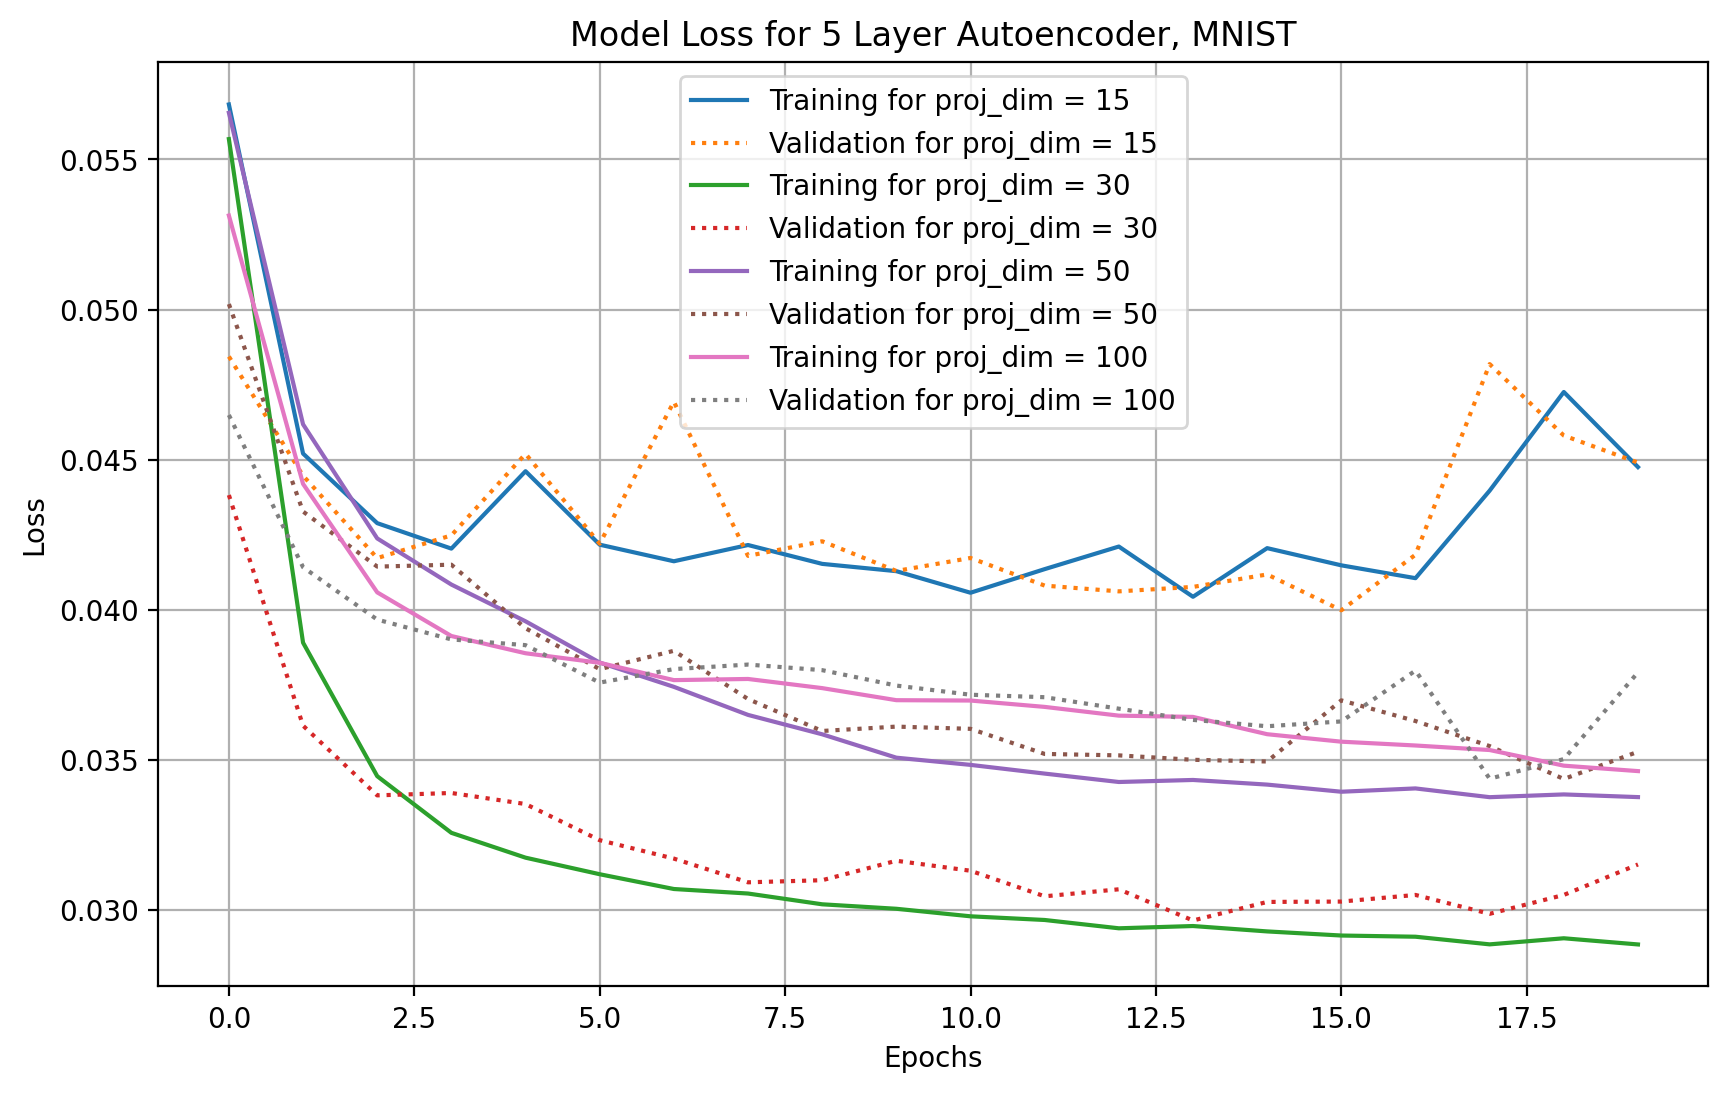

In [17]:
# MNIST
fig = plt.figure(figsize=(10, 6))
for i in range(0,len(proj_dim_list)):

    label_training = str("Training for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, l5_training_loss_all[i],label = label_training)

    label_validation = str("Validation for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, l5_validation_loss_all[i], linestyle='dotted',label = label_validation)
    
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Model Loss for 5 Layer Autoencoder, MNIST')
plt.legend()
plt.show()

5 layer model for FMNIST dataset. Validation and training results as a function of epochs.

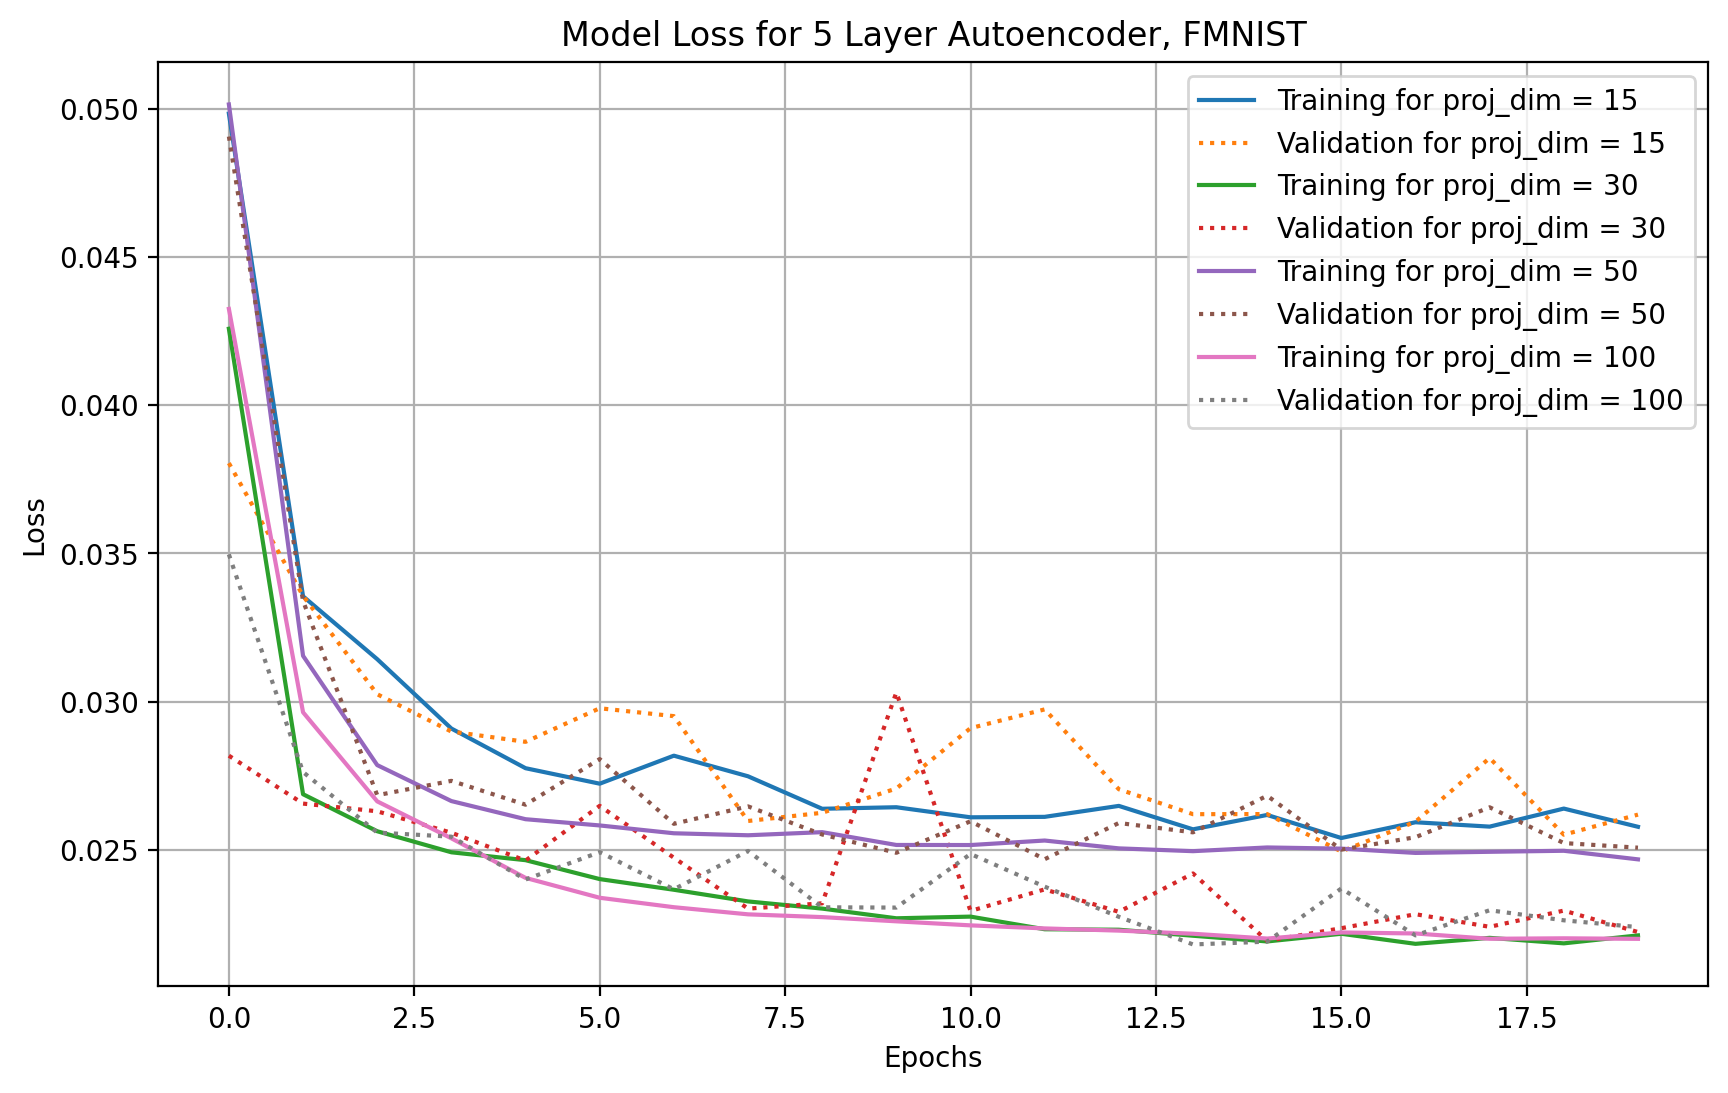

In [18]:
fig = plt.figure(figsize=(10, 6))
for i in range(0,len(proj_dim_list)):

    label_training = str("Training for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, Fl5_training_loss_all[i],label = label_training)

    label_validation = str("Validation for proj_dim = " + str(proj_dim_list[i]))
    plt.plot(epoch_list, Fl5_validation_loss_all[i], linestyle='dotted',label = label_validation)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Model Loss for 5 Layer Autoencoder, FMNIST')
plt.legend()
plt.show()

It is clear to see that in both the 3 layer and 5 layer naive models (with no regularization), there is no sign of overfitting and that both the validation and training set loss converge to similar values as we increase the number of epochs. 

The following section is dedicated to the autoencoders with regularization, specifically the use of the Dropout technique to prevent future overfitting.

---

## Autoencoder with 3 layers both Encoder and Decoder with Regularization.

In [15]:
class Autoencoder_3(nn.Module):
    def __init__(self, input_output_dim, latent_dim, hid1, hid2, epochs=30, lr=1e-3, prob=0.1):
        super().__init__()

        self.lr = lr
        self.epochs = epochs
        self.criterion = nn.MSELoss()

        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.dropout = nn.Dropout(p=prob)

        self.encoder = nn.Sequential(
            nn.Linear(input_output_dim, hid1),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(hid1, hid2),  
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(hid2, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hid2),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(hid2, hid1),  
            nn.ReLU(),
            nn.Dropout(p=prob),  
            nn.Linear(hid1, input_output_dim),
            nn.Sigmoid()
        )

        self.optim = optim.Adam(self.parameters(), self.lr)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):
            running_loss = 0.

            for images,_ in trainloader: 
                images = to_device(images, device)

                self.optim.zero_grad()

                images = images.reshape(-1, 28*28)
                
                out = self.forward(images)

                loss = self.criterion(out, images)

                loss.backward()
                self.optim.step()

                running_loss += loss.item()
            
            self.loss_during_training.append(running_loss/len(trainloader_mnist))

            # validation
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                for images, _ in validloader:
                    images = to_device(images, device)
                    images = images.reshape(-1, 28*28)

                    out = self.forward(images)

                    loss = self.criterion(out, images)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

#### Training of MNIST for all latent dimensions, 6 layers

In [16]:
best_model = None
best_validation_loss = float('inf')

total_train_mnist_3 = []
total_validation_mnist_3 = []

for i in [15, 30, 50, 100]:
    model = Autoencoder_3(input_output_dim=28*28, latent_dim=i, hid1=256, hid2=128, epochs=20, lr=0.01)
    to_device(model, device)

    model.trainloop(trainloader_mnist, validloader_mnist)

    total_train_mnist_3.append(model.loss_during_training)
    total_validation_mnist_3.append(model.valid_loss_during_training)
    
    # Check if the current model has the lowest validation loss among all latent dimensions
    if min(model.valid_loss_during_training) < best_validation_loss:
        best_model = model
        best_validation_loss = min(model.valid_loss_during_training)

# Save the best model
torch.save(best_model.state_dict(), 'best_model_mnist_3.pth')

# state_dict = torch.load('checkpoint.pth')
# my_MLP.load_state_dict(state_dict)

Epoch 0. Training loss: 0.047385, Validation loss: 0.034639
Epoch 1. Training loss: 0.037305, Validation loss: 0.032094
Epoch 2. Training loss: 0.036193, Validation loss: 0.031599
Epoch 3. Training loss: 0.035840, Validation loss: 0.031672
Epoch 4. Training loss: 0.035378, Validation loss: 0.029911
Epoch 5. Training loss: 0.035133, Validation loss: 0.030386
Epoch 6. Training loss: 0.035007, Validation loss: 0.029703
Epoch 7. Training loss: 0.034910, Validation loss: 0.029713
Epoch 8. Training loss: 0.034904, Validation loss: 0.029893
Epoch 9. Training loss: 0.034837, Validation loss: 0.030299
Epoch 10. Training loss: 0.035017, Validation loss: 0.029645
Epoch 11. Training loss: 0.034638, Validation loss: 0.030180
Epoch 12. Training loss: 0.034836, Validation loss: 0.029312
Epoch 13. Training loss: 0.034737, Validation loss: 0.029342
Epoch 14. Training loss: 0.034837, Validation loss: 0.029462
Epoch 15. Training loss: 0.034681, Validation loss: 0.029783
Epoch 16. Training loss: 0.034585,

##### Loss results

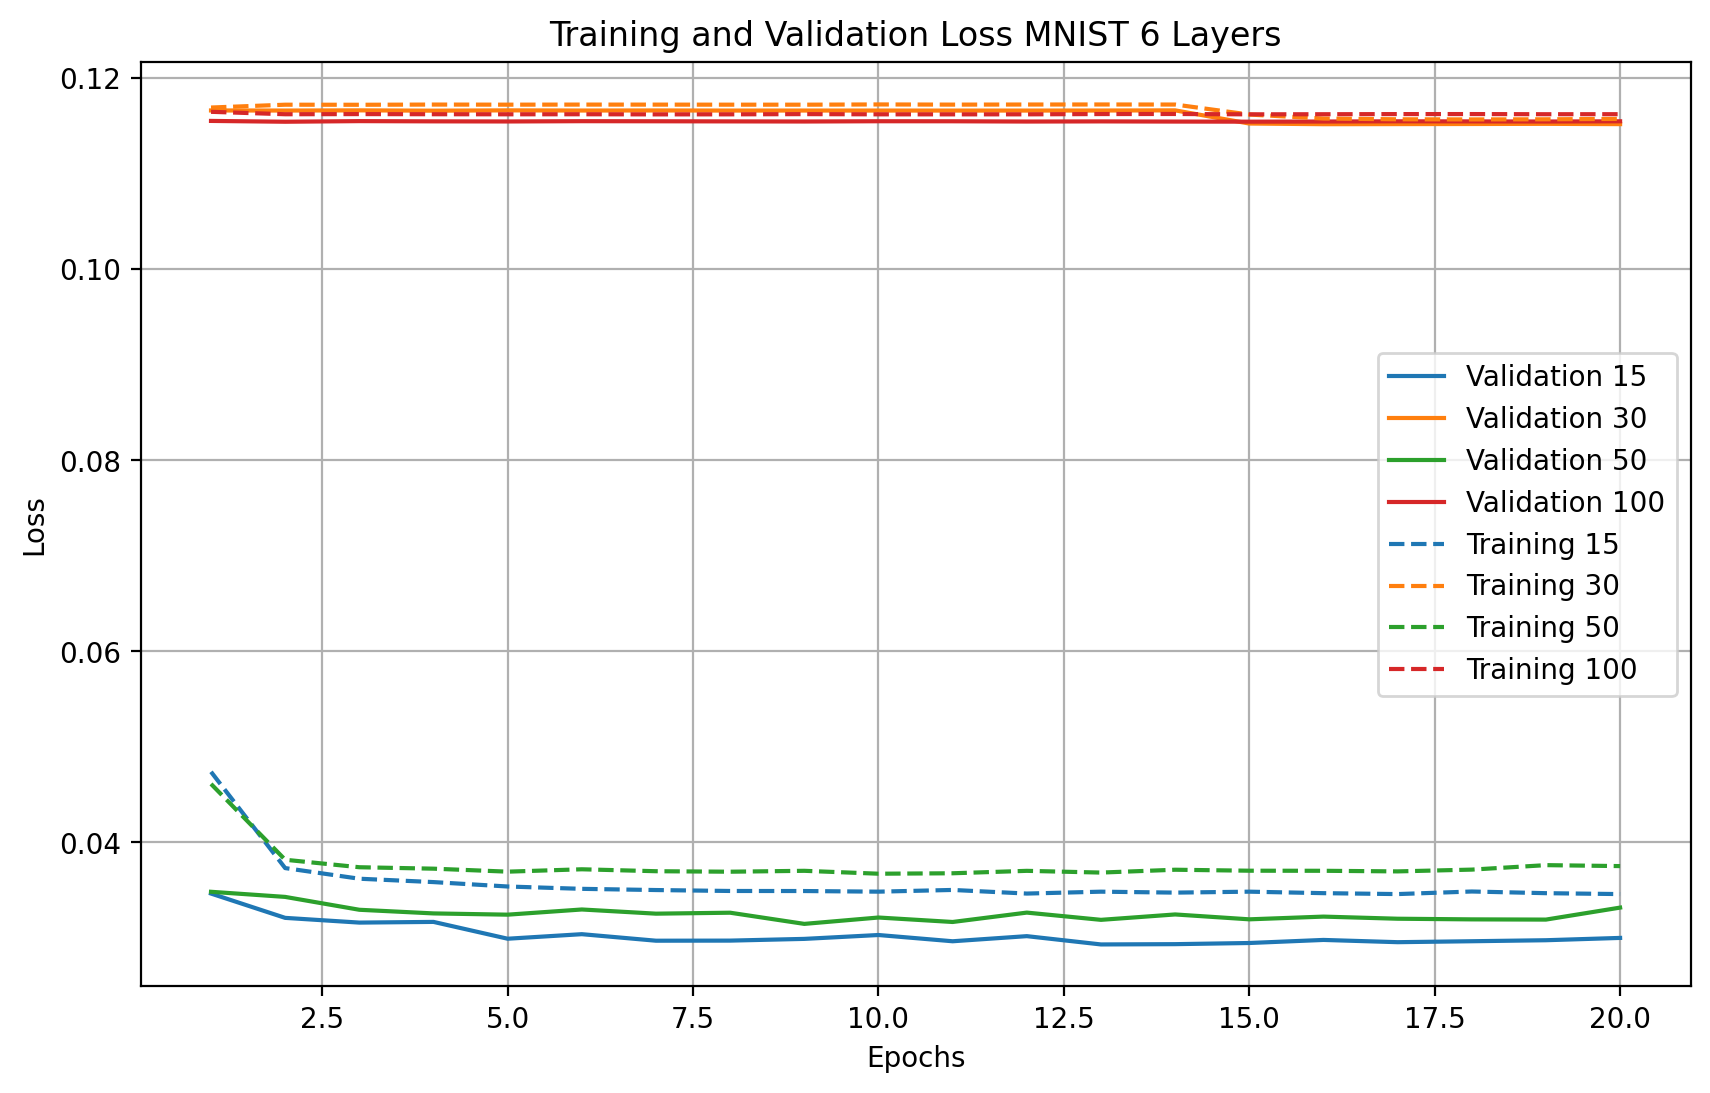

In [17]:
latent_dim = [15, 30, 50, 100]
epochs = range(1, len(total_validation_mnist_3[0]) + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot validation loss
for i, loss_type in enumerate(total_validation_mnist_3):
    plt.plot(epochs, loss_type, label=f'Validation {latent_dim[i]}', color=f'C{i}', linestyle='-')

# Plot training loss
for i, loss_type in enumerate(total_train_mnist_3):
    plt.plot(epochs, loss_type, label=f'Training {latent_dim[i]}', color=f'C{i}', linestyle='--')

plt.title('Training and Validation Loss MNIST 6 Layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Best model has latent dimension of 15

#### Training models of FMNIST for all latent dimensions, 6 layers

In [27]:
best_model = None
best_validation_loss = float('inf')

total_train_fmnist_3 = []
total_validation_fmnist_3 = []

for i in [15, 30, 50, 100]:
    model = Autoencoder_3(input_output_dim=28*28, latent_dim=i, hid1=256, hid2=128, epochs=15, lr=0.01)
    to_device(model, device)

    model.trainloop(trainloader_fmnist, validloader_fmnist)

    total_train_fmnist_3.append(model.loss_during_training)
    total_validation_fmnist_3.append(model.valid_loss_during_training)
    
    # Check if the current model has the lowest validation loss among all latent dimensions
    if min(model.valid_loss_during_training) < best_validation_loss:
        best_model = model
        best_validation_loss = min(model.valid_loss_during_training)

# Save the best model
torch.save(best_model.state_dict(), 'best_model_fmnist_3.pth')

Epoch 0. Training loss: 0.036820, Validation loss: 0.028724
Epoch 1. Training loss: 0.030328, Validation loss: 0.026366
Epoch 2. Training loss: 0.029968, Validation loss: 0.027287
Epoch 3. Training loss: 0.029660, Validation loss: 0.025299
Epoch 4. Training loss: 0.029801, Validation loss: 0.026411
Epoch 5. Training loss: 0.030257, Validation loss: 0.028146
Epoch 6. Training loss: 0.030889, Validation loss: 0.029798
Epoch 7. Training loss: 0.031049, Validation loss: 0.026045
Epoch 8. Training loss: 0.030480, Validation loss: 0.026581
Epoch 9. Training loss: 0.031353, Validation loss: 0.027980
Epoch 10. Training loss: 0.030991, Validation loss: 0.026052
Epoch 11. Training loss: 0.031192, Validation loss: 0.028262
Epoch 12. Training loss: 0.031594, Validation loss: 0.028974
Epoch 13. Training loss: 0.030803, Validation loss: 0.026669
Epoch 14. Training loss: 0.031737, Validation loss: 0.026677
Epoch 0. Training loss: 0.037060, Validation loss: 0.028612
Epoch 1. Training loss: 0.030618, V

##### Loss results

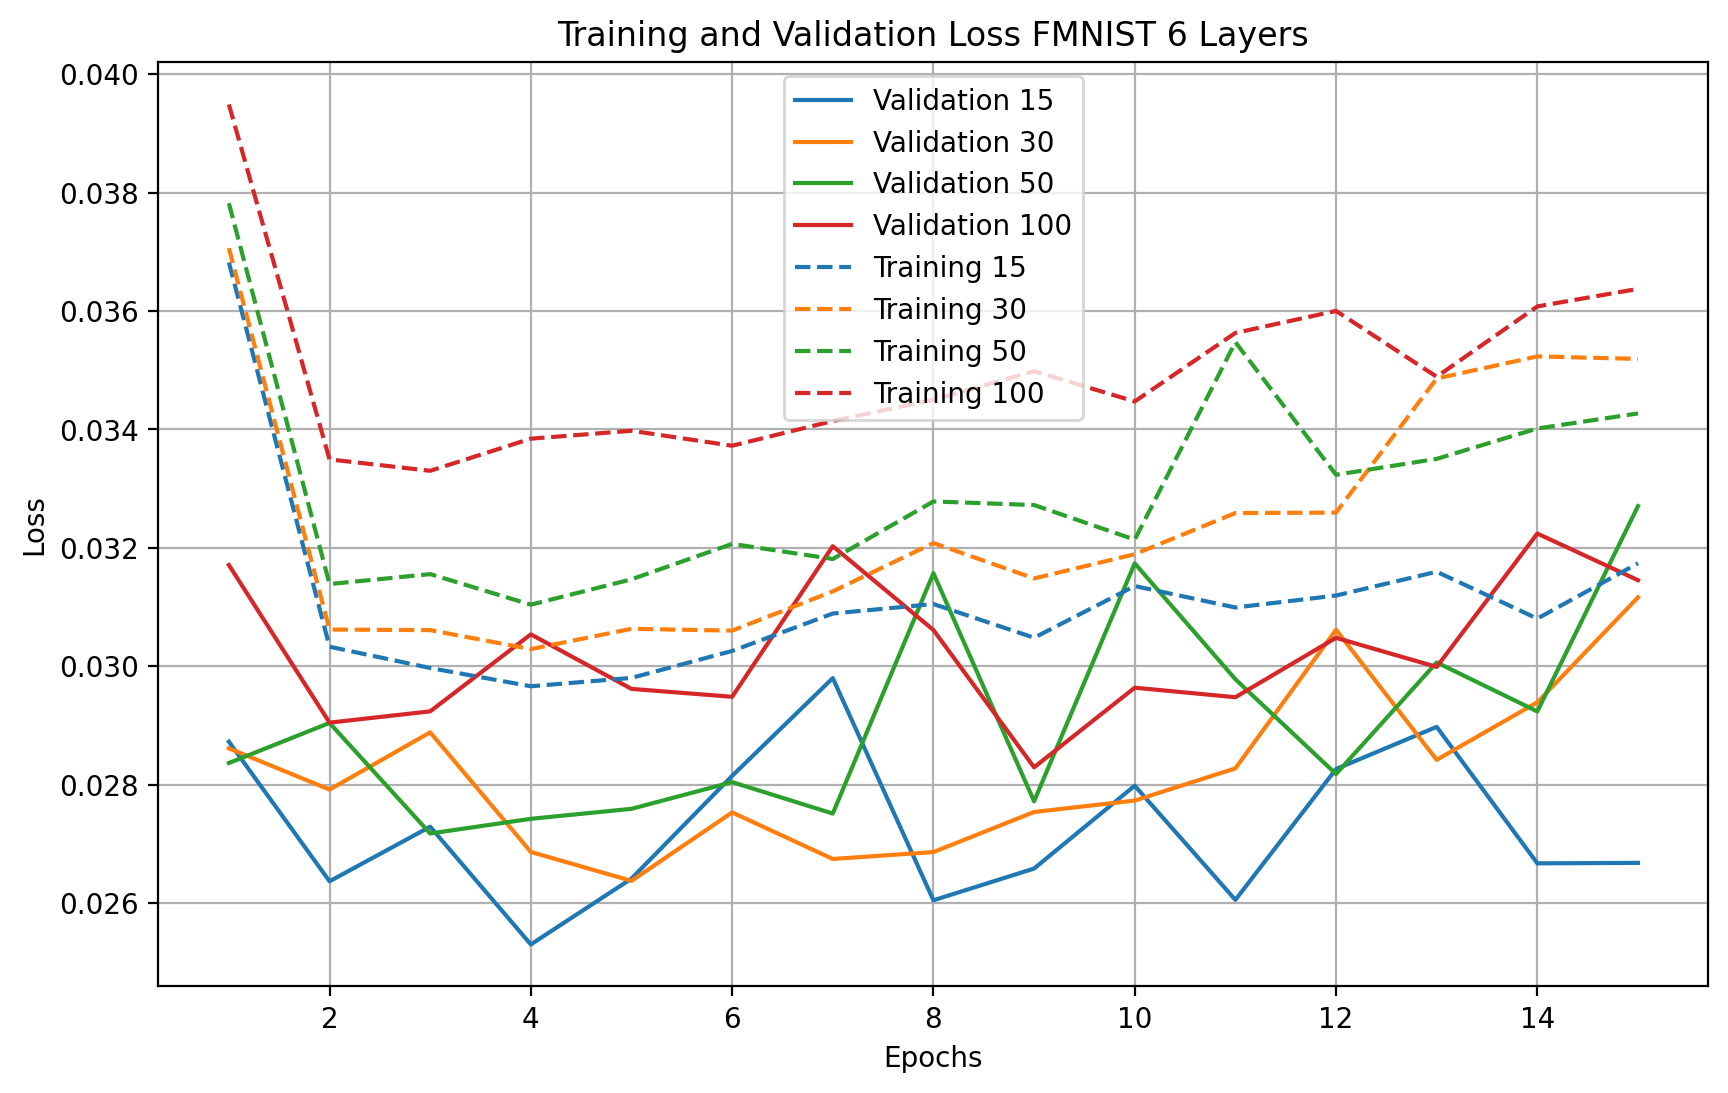

In [28]:
latent_dim = [15, 30, 50, 100]
epochs = range(1, len(total_validation_fmnist_3[0]) + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot validation loss
for i, loss_type in enumerate(total_validation_fmnist_3):
    plt.plot(epochs, loss_type, label=f'Validation {latent_dim[i]}', color=f'C{i}', linestyle='-')

# Plot training loss
for i, loss_type in enumerate(total_train_fmnist_3):
    plt.plot(epochs, loss_type, label=f'Training {latent_dim[i]}', color=f'C{i}', linestyle='--')

plt.title('Training and Validation Loss FMNIST 6 Layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Best latent dimension 15

## Autoencoder with 5 layers in both encoder and decoder

In [29]:
class Autoencoder_5(nn.Module):
    def __init__(self, input_output_dim, latent_dim, hid1, hid2, hid3, hid4, epochs=30, lr=1e-3, prob=0.1):
        super().__init__()

        self.lr = lr
        self.epochs = epochs

        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.dropout = nn.Dropout(p=prob)

        self.encoder = nn.Sequential(
            nn.Linear(input_output_dim, hid1),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(hid1, hid2),  
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(hid2, hid3),  
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(hid3, hid4),  
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(hid4, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hid4),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(hid4, hid3),  
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(hid3, hid2),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(hid2, hid1),  
            nn.ReLU(), 
            nn.Dropout(p=prob),  
            nn.Linear(hid1, input_output_dim),
            nn.Sigmoid()
        )

        self.criterion = nn.MSELoss()
        self.optim = optim.Adam(self.parameters(), self.lr)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):
            running_loss = 0.

            for images,_ in trainloader: 
                images = to_device(images, device)

                self.optim.zero_grad()

                images = images.reshape(-1, 28*28)
                
                out = self.forward(images)

                loss = self.criterion(out, images)

                loss.backward()
                self.optim.step()

                running_loss += loss.item()
            
            self.loss_during_training.append(running_loss/len(trainloader_mnist))

            # validation
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_loss = 0.
                
                for images, _ in validloader:
                    images = to_device(images, device)
                    images = images.reshape(-1, 28*28)

                    out = self.forward(images)

                    loss = self.criterion(out, images)

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))

#### Training and validating for MNIST

In [30]:
best_model = None
best_validation_loss = float('inf')

total_train_mnist_5 = []
total_validation_mnist_5 = []

for i in [15, 30, 50, 100]:
    model = Autoencoder_5(input_output_dim=28*28, latent_dim=i, hid1=512, hid2=256, hid3=128, hid4=64, epochs=15, lr=0.01)
    to_device(model, device)

    model.trainloop(trainloader_mnist, validloader_mnist)

    total_train_mnist_5.append(model.loss_during_training)
    total_validation_mnist_5.append(model.valid_loss_during_training)
    
    # Check if the current model has the lowest validation loss among all latent dimensions
    if min(model.valid_loss_during_training) < best_validation_loss:
        best_model = model
        best_validation_loss = min(model.valid_loss_during_training)

# Save the best model
torch.save(best_model.state_dict(), 'best_model_mnist_5.pth')

Epoch 0. Training loss: 0.058696, Validation loss: 0.052597
Epoch 1. Training loss: 0.055717, Validation loss: 0.052047
Epoch 2. Training loss: 0.055087, Validation loss: 0.051055
Epoch 3. Training loss: 0.055523, Validation loss: 0.051763
Epoch 4. Training loss: 0.056190, Validation loss: 0.053408
Epoch 5. Training loss: 0.056046, Validation loss: 0.052894
Epoch 6. Training loss: 0.056551, Validation loss: 0.053111
Epoch 7. Training loss: 0.057930, Validation loss: 0.056908
Epoch 8. Training loss: 0.060806, Validation loss: 0.059687
Epoch 9. Training loss: 0.061370, Validation loss: 0.058066
Epoch 10. Training loss: 0.060361, Validation loss: 0.063214
Epoch 11. Training loss: 0.064972, Validation loss: 0.064203
Epoch 12. Training loss: 0.064756, Validation loss: 0.063726
Epoch 13. Training loss: 0.064488, Validation loss: 0.063697
Epoch 14. Training loss: 0.064517, Validation loss: 0.063817
Epoch 0. Training loss: 0.115211, Validation loss: 0.114202
Epoch 1. Training loss: 0.114955, V

##### Loss results

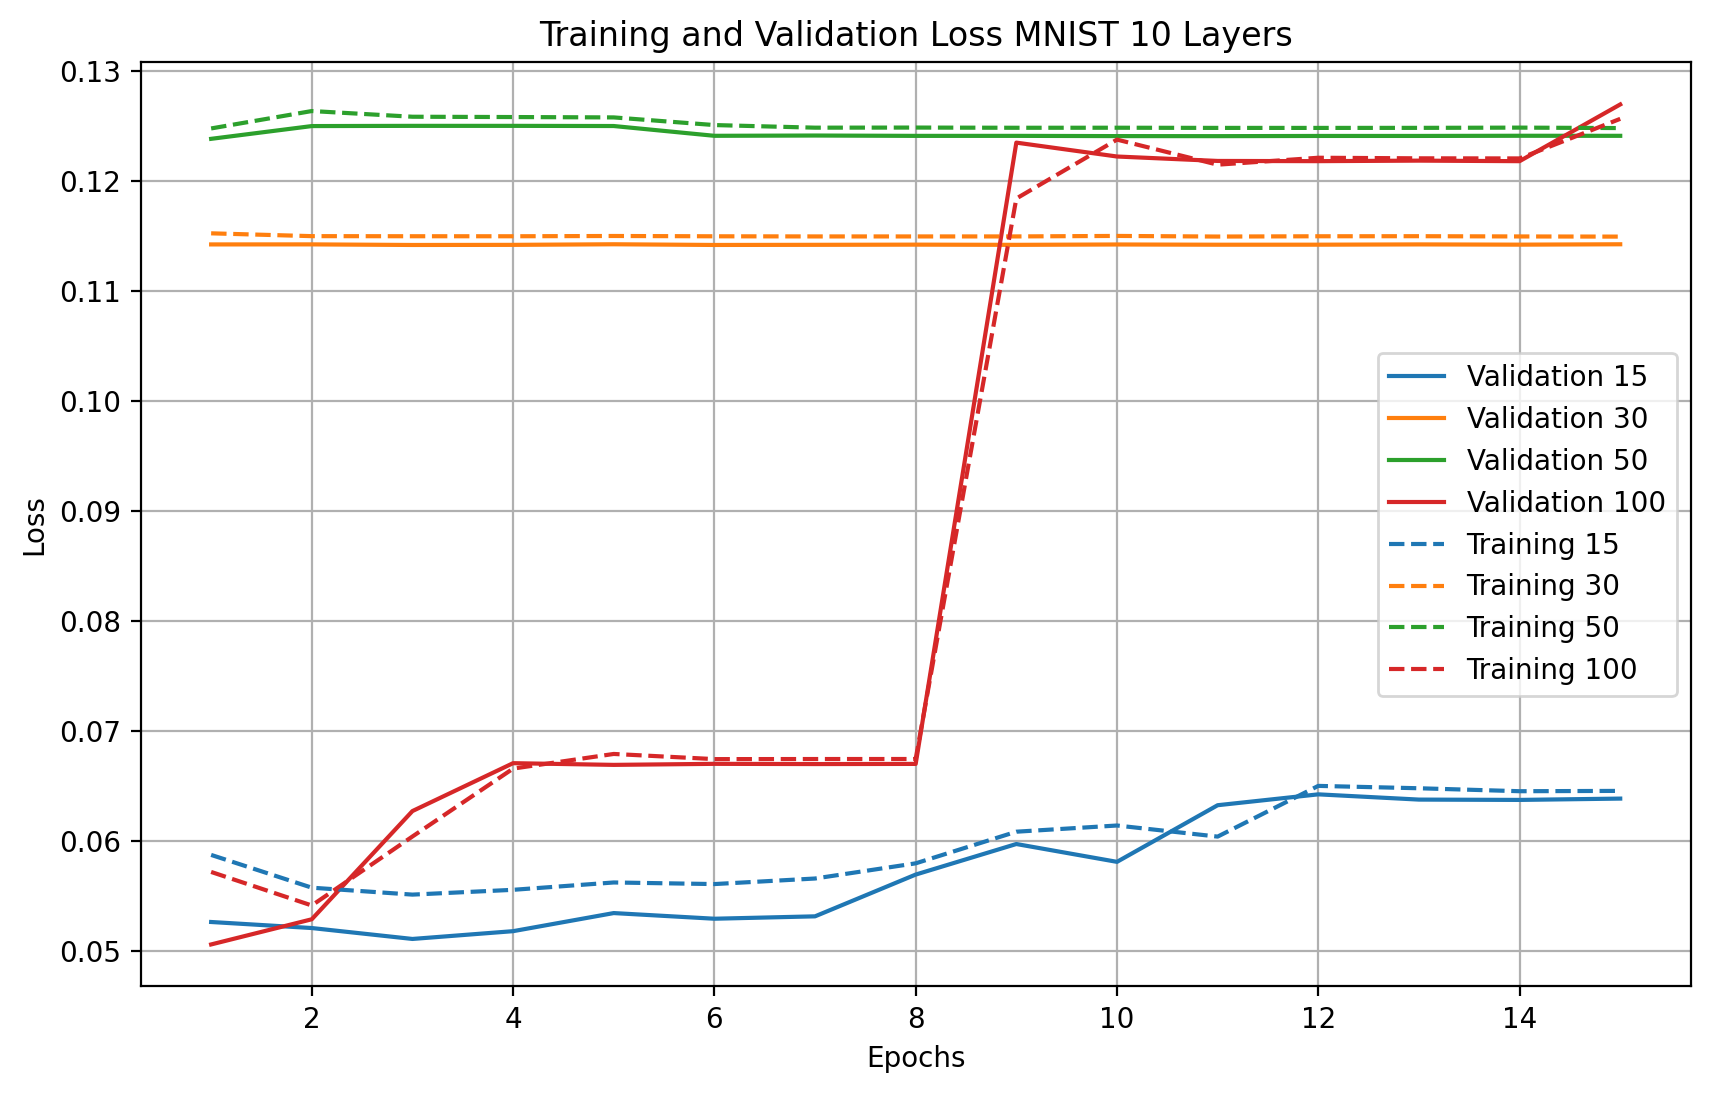

In [31]:
latent_dim = [15, 30, 50, 100]
epochs = range(1, len(total_validation_mnist_5[0]) + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot validation loss
for i, loss_type in enumerate(total_validation_mnist_5):
    plt.plot(epochs, loss_type, label=f'Validation {latent_dim[i]}', color=f'C{i}', linestyle='-')

# Plot training loss
for i, loss_type in enumerate(total_train_mnist_5):
    plt.plot(epochs, loss_type, label=f'Training {latent_dim[i]}', color=f'C{i}', linestyle='--')

plt.title('Training and Validation Loss MNIST 10 Layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The best model has latent dimension 100

#### Training and validating for FMNIST

In [32]:
best_model = None
best_validation_loss = float('inf')

total_train_fmnist_5 = []
total_validation_fmnist_5 = []

for i in [15, 30, 50, 100]:
    model = Autoencoder_5(input_output_dim=28*28, latent_dim=i, hid1=512, hid2=256, hid3=128, hid4=64, epochs=15, lr=0.01)
    to_device(model, device)

    model.trainloop(trainloader_fmnist, validloader_fmnist)

    total_train_fmnist_5.append(model.loss_during_training)
    total_validation_fmnist_5.append(model.valid_loss_during_training)
    
    # Check if the current model has the lowest validation loss among all latent dimensions
    if min(model.valid_loss_during_training) < best_validation_loss:
        best_model = model
        best_validation_loss = min(model.valid_loss_during_training)

# Save the best model
torch.save(best_model.state_dict(), 'best_model_fmnist_5.pth')

Epoch 0. Training loss: 0.053089, Validation loss: 0.041299
Epoch 1. Training loss: 0.044141, Validation loss: 0.040745
Epoch 2. Training loss: 0.046311, Validation loss: 0.044408
Epoch 3. Training loss: 0.046660, Validation loss: 0.040811
Epoch 4. Training loss: 0.054784, Validation loss: 0.053940
Epoch 5. Training loss: 0.052553, Validation loss: 0.046084
Epoch 6. Training loss: 0.056757, Validation loss: 0.068495
Epoch 7. Training loss: 0.070969, Validation loss: 0.066794
Epoch 8. Training loss: 0.068787, Validation loss: 0.058963
Epoch 9. Training loss: 0.066405, Validation loss: 0.059405
Epoch 10. Training loss: 0.065781, Validation loss: 0.061701
Epoch 11. Training loss: 0.067638, Validation loss: 0.062767
Epoch 12. Training loss: 0.067105, Validation loss: 0.060284
Epoch 13. Training loss: 0.066796, Validation loss: 0.063763
Epoch 14. Training loss: 0.066523, Validation loss: 0.061324
Epoch 0. Training loss: 0.052766, Validation loss: 0.044094
Epoch 1. Training loss: 0.043091, V

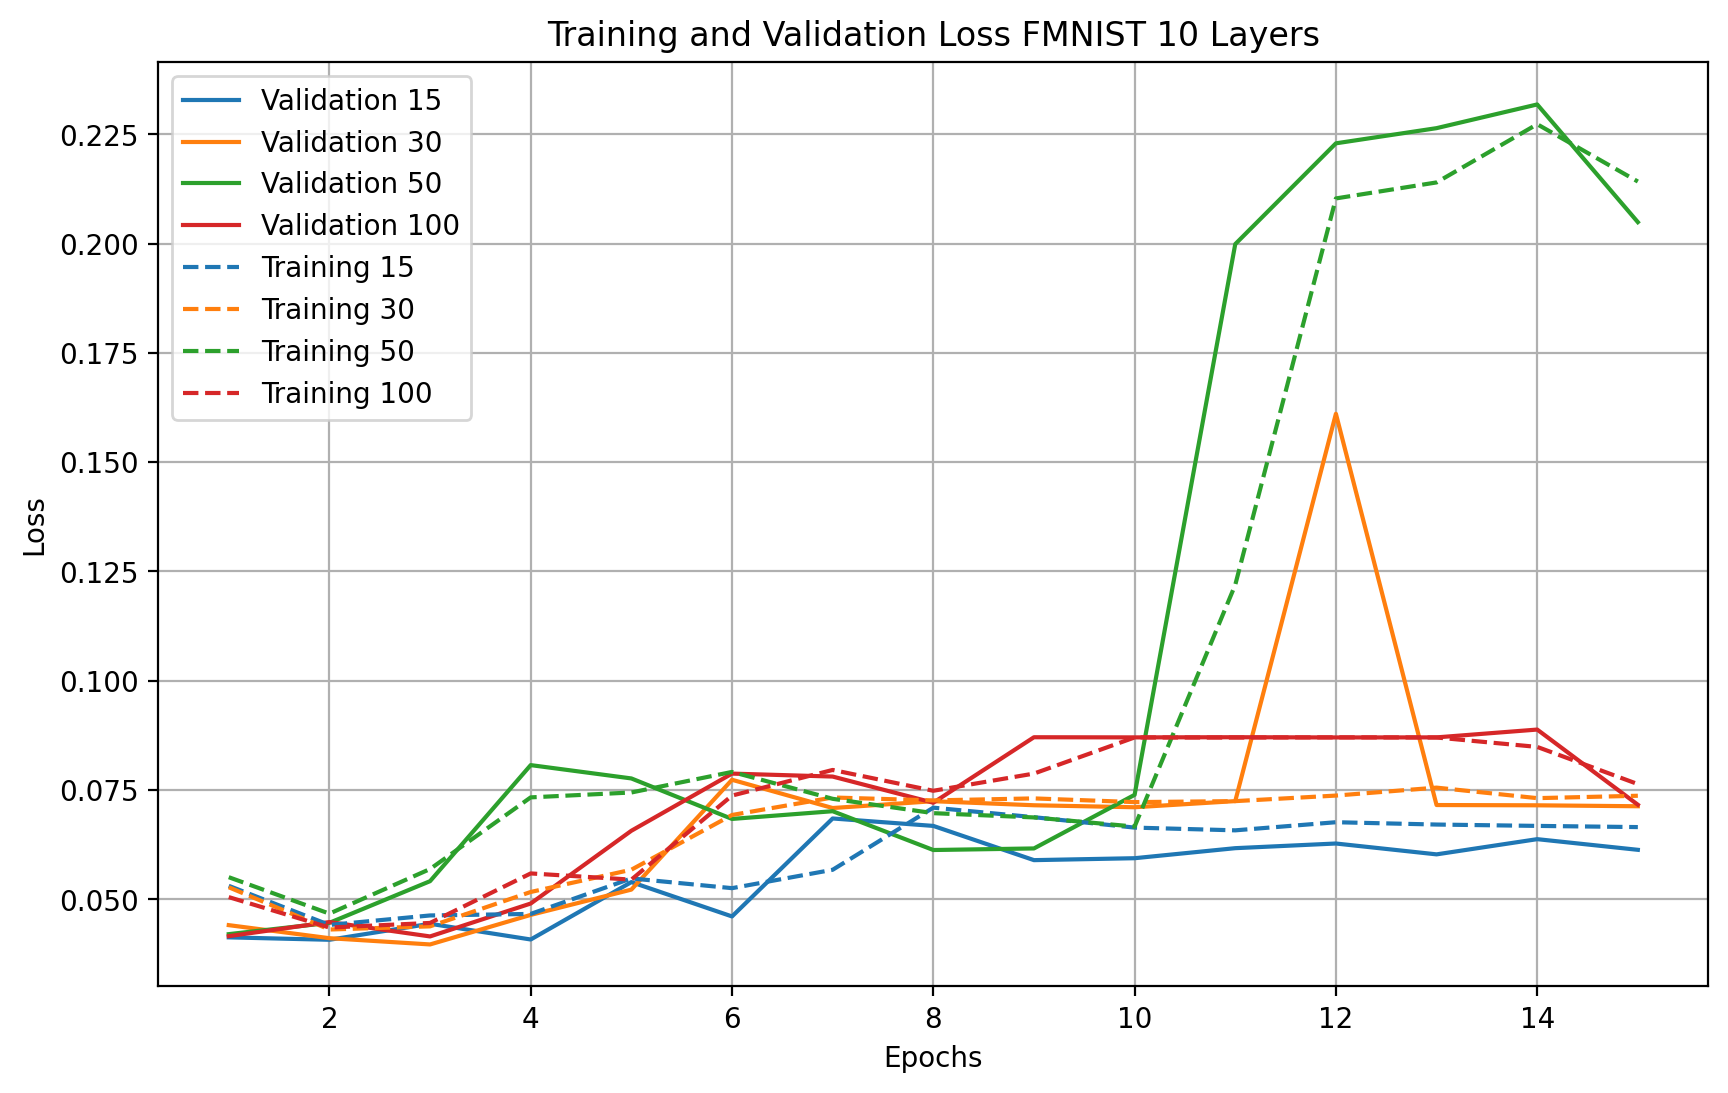

In [33]:
latent_dim = [15, 30, 50, 100]
epochs = range(1, len(total_validation_fmnist_5[0]) + 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot validation loss
for i, loss_type in enumerate(total_validation_fmnist_5):
    plt.plot(epochs, loss_type, label=f'Validation {latent_dim[i]}', color=f'C{i}', linestyle='-')

# Plot training loss
for i, loss_type in enumerate(total_train_fmnist_5):
    plt.plot(epochs, loss_type, label=f'Training {latent_dim[i]}', color=f'C{i}', linestyle='--')

plt.title('Training and Validation Loss FMNIST 10 Layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Best model has latent dimension 30

We are now done with the training and have the best models for each part, now we need to compare the results

## Best models

For MNIST database best model found was 6 layers 15 nodes in latent dimension

For FMNIST database best model found was 6 layers 15 nodes in latent dimension

Now we load the saved best models for each database

In [36]:
mnist_model = Autoencoder_3(input_output_dim=28*28, latent_dim=15, hid1=256, hid2=128)
state_dict = torch.load("best_model_mnist_3.pth")
mnist_model.load_state_dict(state_dict)

fmnist_model = Autoencoder_3(input_output_dim=28*28, latent_dim=15, hid1=256, hid2=128)
state_dict = torch.load("best_model_fmnist_3.pth")
fmnist_model.load_state_dict(state_dict)
#mnist_model.load_state_dict(torch.load("C:/Users/casan/Desktop/uc3m/3/Redes Neuronales/Project 1/best_model_mnist_3.pt", map_location=device))
#mnist_model.eval()

#fmnist_model = Autoencoder_3(input_output_dim=28*28, latent_dim=50, hid1=256, hid2=128)
#fmnist_model.load_state_dict(torch.load("C:/Users/casan/Desktop/uc3m/3/Redes Neuronales/Project 1/best_model_fmnist_3.pt", map_location=device))
#fmnist_model.eval()

<All keys matched successfully>

In [37]:
mnist_model.eval()
fmnist_model.eval()

Autoencoder_3(
  (criterion): MSELoss()
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=15, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

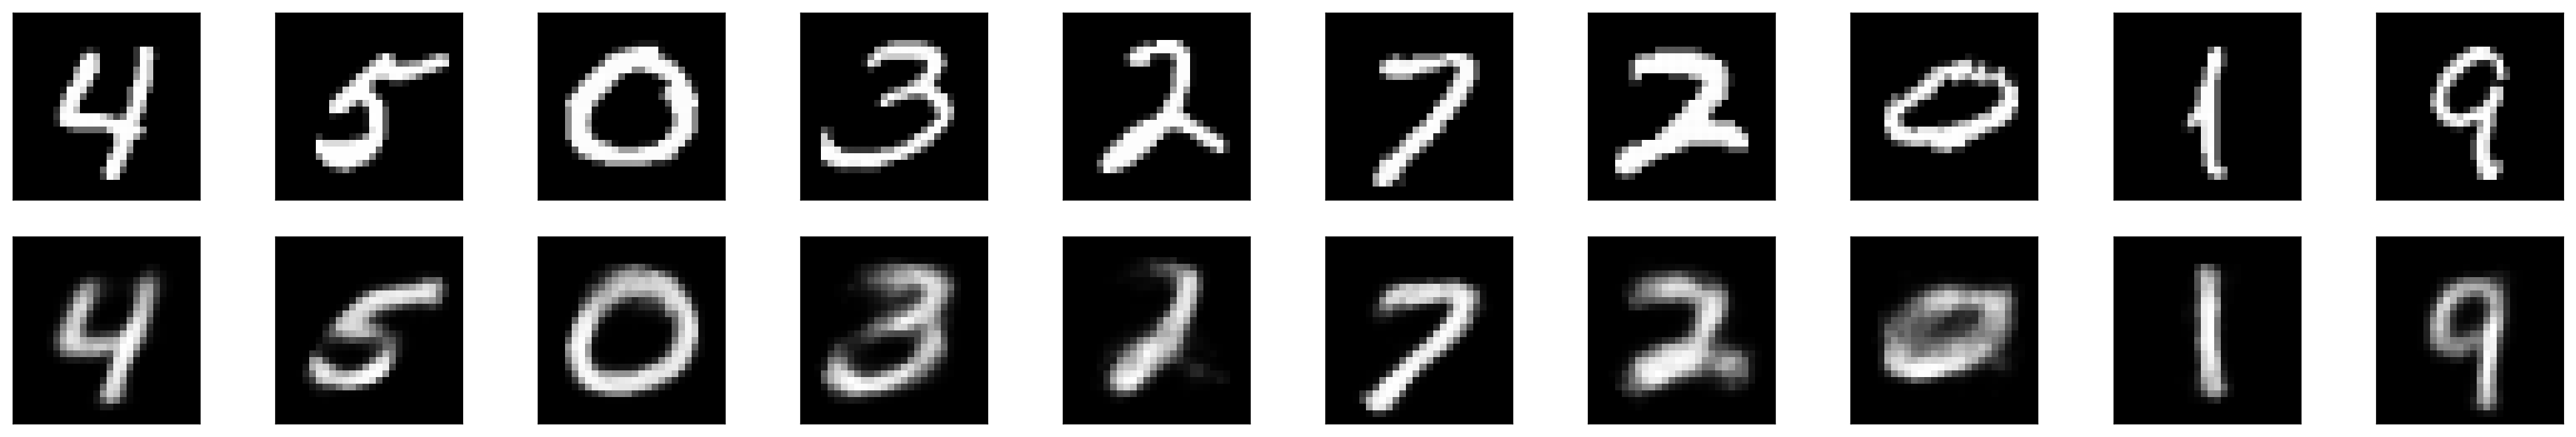

In [26]:
# model.cpu()
# obtain one batch of test images
dataiter = iter(testloader_mnist)
images, _ = next(dataiter)
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = mnist_model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

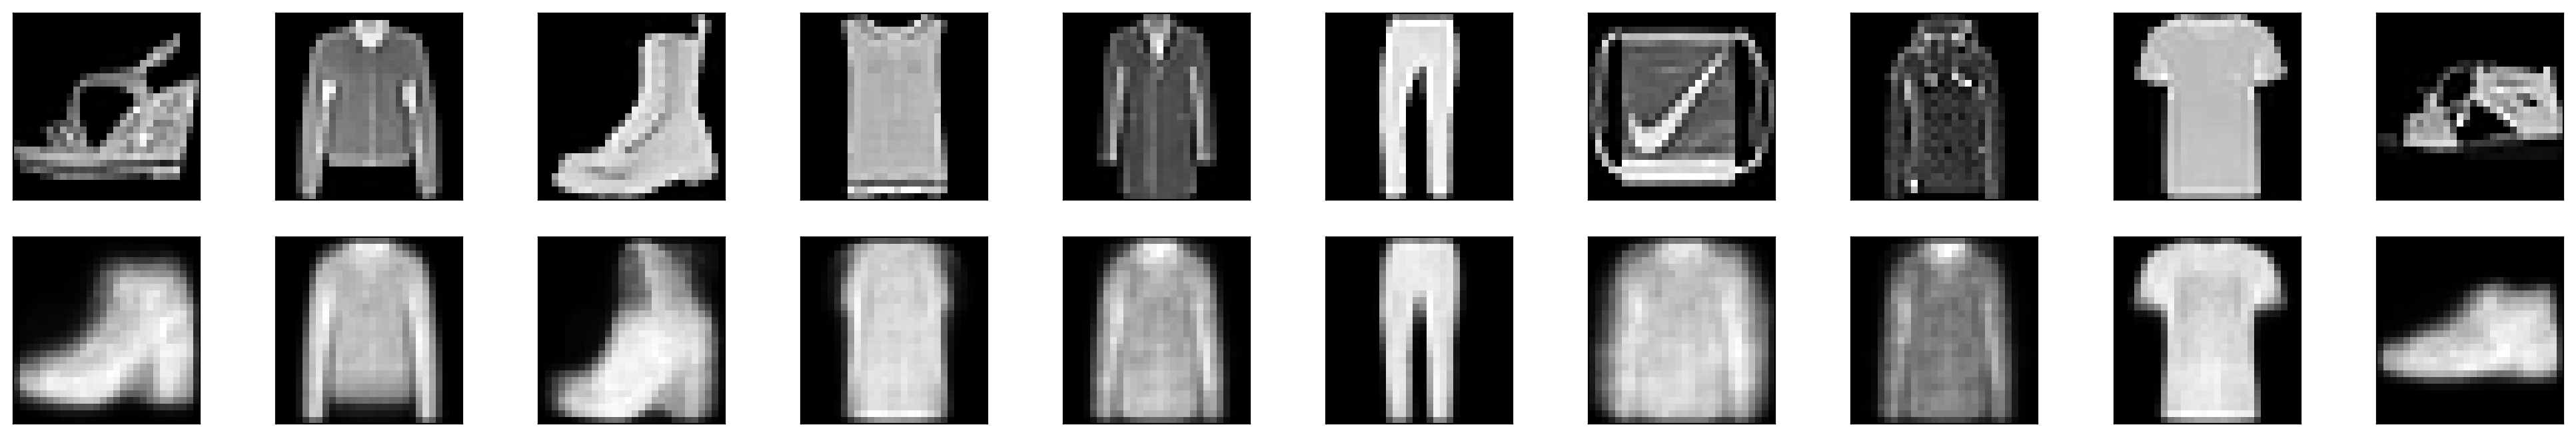

In [41]:
dataiter = iter(testloader_fmnist)
images, _ = next(dataiter)
images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = fmnist_model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Denoising Autoencoder

We now define, using our best validated model architecture, the denoising autoencoder for training and measurement with respect to the PSNR metric.

Define noise function: 

In [1]:
def add_gaussian_noise(images, noise_level=0.1):
    noise = torch.randn_like(images) * noise_level
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

In [8]:
class Denoising_Autoencoder(nn.Module):
    def __init__(self, epochs=30, lr=1e-3, prob=0.1, noise_level=0.5):
        super().__init__()

        self.lr = lr
        self.epochs = epochs
        self.noise_level = noise_level
        self.criterion = nn.MSELoss()

        self.PSNR_during_training = []
        self.valid_PSNR_during_training = []

        self.dropout = nn.Dropout(p=prob)

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(128, 15)
        )

        self.decoder = nn.Sequential(
            nn.Linear(15, 128),  
            nn.ReLU(), 
            nn.Dropout(p=prob),
            nn.Linear(128, 256),  
            nn.ReLU(),
            nn.Dropout(p=prob),  
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

        self.optim = optim.Adam(self.parameters(), self.lr)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):
            running_psnr = 0.

            for images,_ in trainloader: 
                images = to_device(images, device)

                self.optim.zero_grad()

                images = images.reshape(-1, 28*28)

                noisy_images = add_gaussian_noise(images, noise_level=self.noise_level)
                
                out = self.forward(noisy_images)

                loss = self.criterion(out, images)

                loss.backward()
                self.optim.step()

                # CALCULATE PSNR
                mse = loss.item()
                psnr = 20 * torch.log10(1. / torch.sqrt(torch.tensor(mse)))
                running_psnr += psnr.item() 
            
            self.PSNR_during_training.append(running_psnr/len(trainloader_mnist))

            # validation
            with torch.no_grad(): 
                
                # set model to evaluation mode
                self.eval()
                
                running_psnr = 0.
                
                for images, _ in validloader:
                    images = to_device(images, device)
                    images = images.reshape(-1, 28*28)

                    noisy_images = add_gaussian_noise(images, noise_level=self.noise_level)

                    out = self.forward(noisy_images)

                    loss = self.criterion(out, images)

                    # CALCULATE PSNR
                    mse = loss.item()
                    psnr = 20 * torch.log10(1. / torch.sqrt(torch.tensor(mse)))
                    running_psnr += psnr.item()    
                    
                self.valid_PSNR_during_training.append(running_psnr/len(validloader))    
                    
            # set model back to train mode
            self.train()
                    
            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training PSNR: %f, Validation PSNR: %f" 
                      %(e,self.PSNR_during_training[-1],self.valid_PSNR_during_training[-1]))

Train for MNIST database

In [18]:
model = Denoising_Autoencoder(epochs=20, lr=0.001, noise_level=0.5)
to_device(model, device)

model.trainloop(trainloader_mnist, validloader_mnist)

Epoch 0. Training PSNR: 12.808925, Validation PSNR: 14.398531
Epoch 1. Training PSNR: 14.546111, Validation PSNR: 15.133544
Epoch 2. Training PSNR: 15.032194, Validation PSNR: 15.591375
Epoch 3. Training PSNR: 15.353235, Validation PSNR: 15.922944
Epoch 4. Training PSNR: 15.580564, Validation PSNR: 16.172862
Epoch 5. Training PSNR: 15.742400, Validation PSNR: 16.388016
Epoch 6. Training PSNR: 15.876075, Validation PSNR: 16.507901
Epoch 7. Training PSNR: 15.979832, Validation PSNR: 16.611485
Epoch 8. Training PSNR: 16.057061, Validation PSNR: 16.729568
Epoch 9. Training PSNR: 16.118879, Validation PSNR: 16.774183
Epoch 10. Training PSNR: 16.177153, Validation PSNR: 16.842919
Epoch 11. Training PSNR: 16.219229, Validation PSNR: 16.899646
Epoch 12. Training PSNR: 16.262195, Validation PSNR: 16.995491
Epoch 13. Training PSNR: 16.282970, Validation PSNR: 16.964256
Epoch 14. Training PSNR: 16.316644, Validation PSNR: 17.047884
Epoch 15. Training PSNR: 16.345852, Validation PSNR: 17.078387
Ep

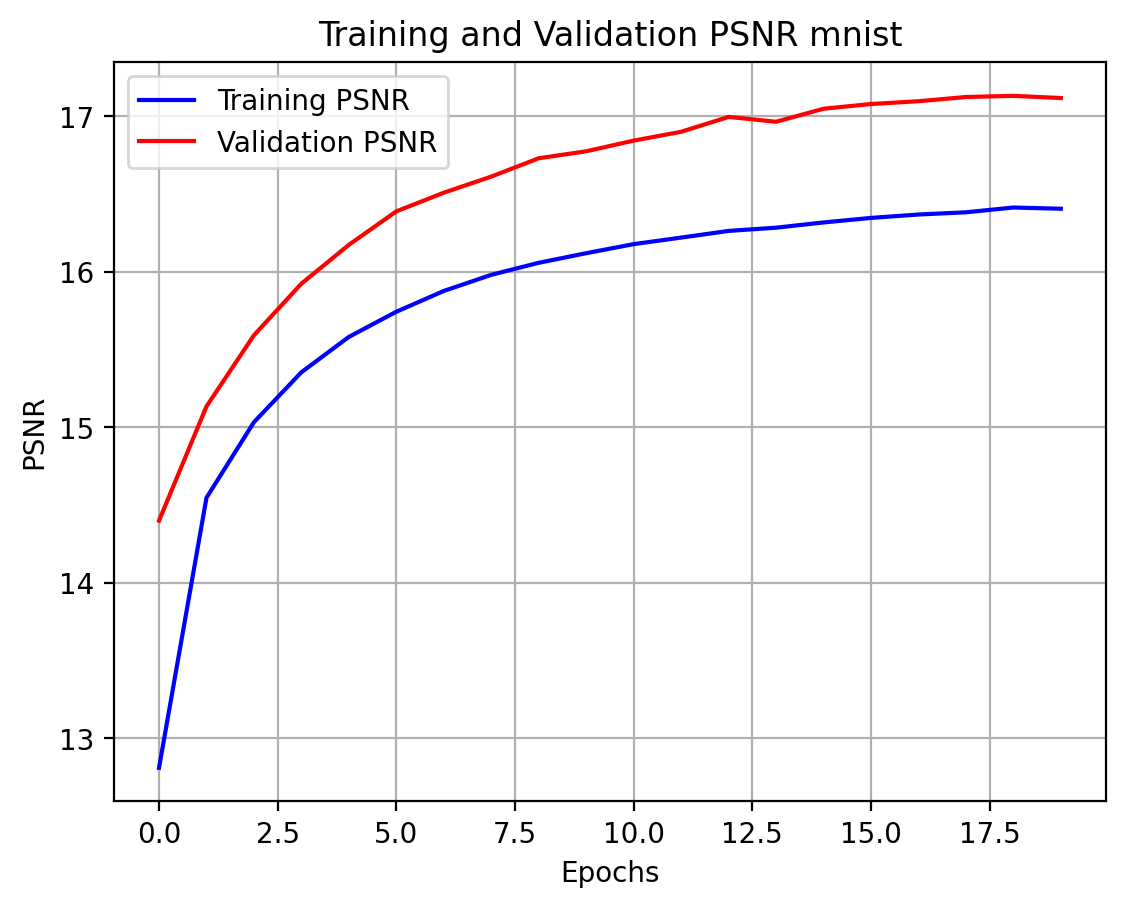

In [19]:
plt.plot(model.PSNR_during_training, color = "blue", label="Training PSNR")
plt.plot(model.valid_PSNR_during_training, color = "red", label="Validation PSNR")
plt.title("Training and Validation PSNR mnist")
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()

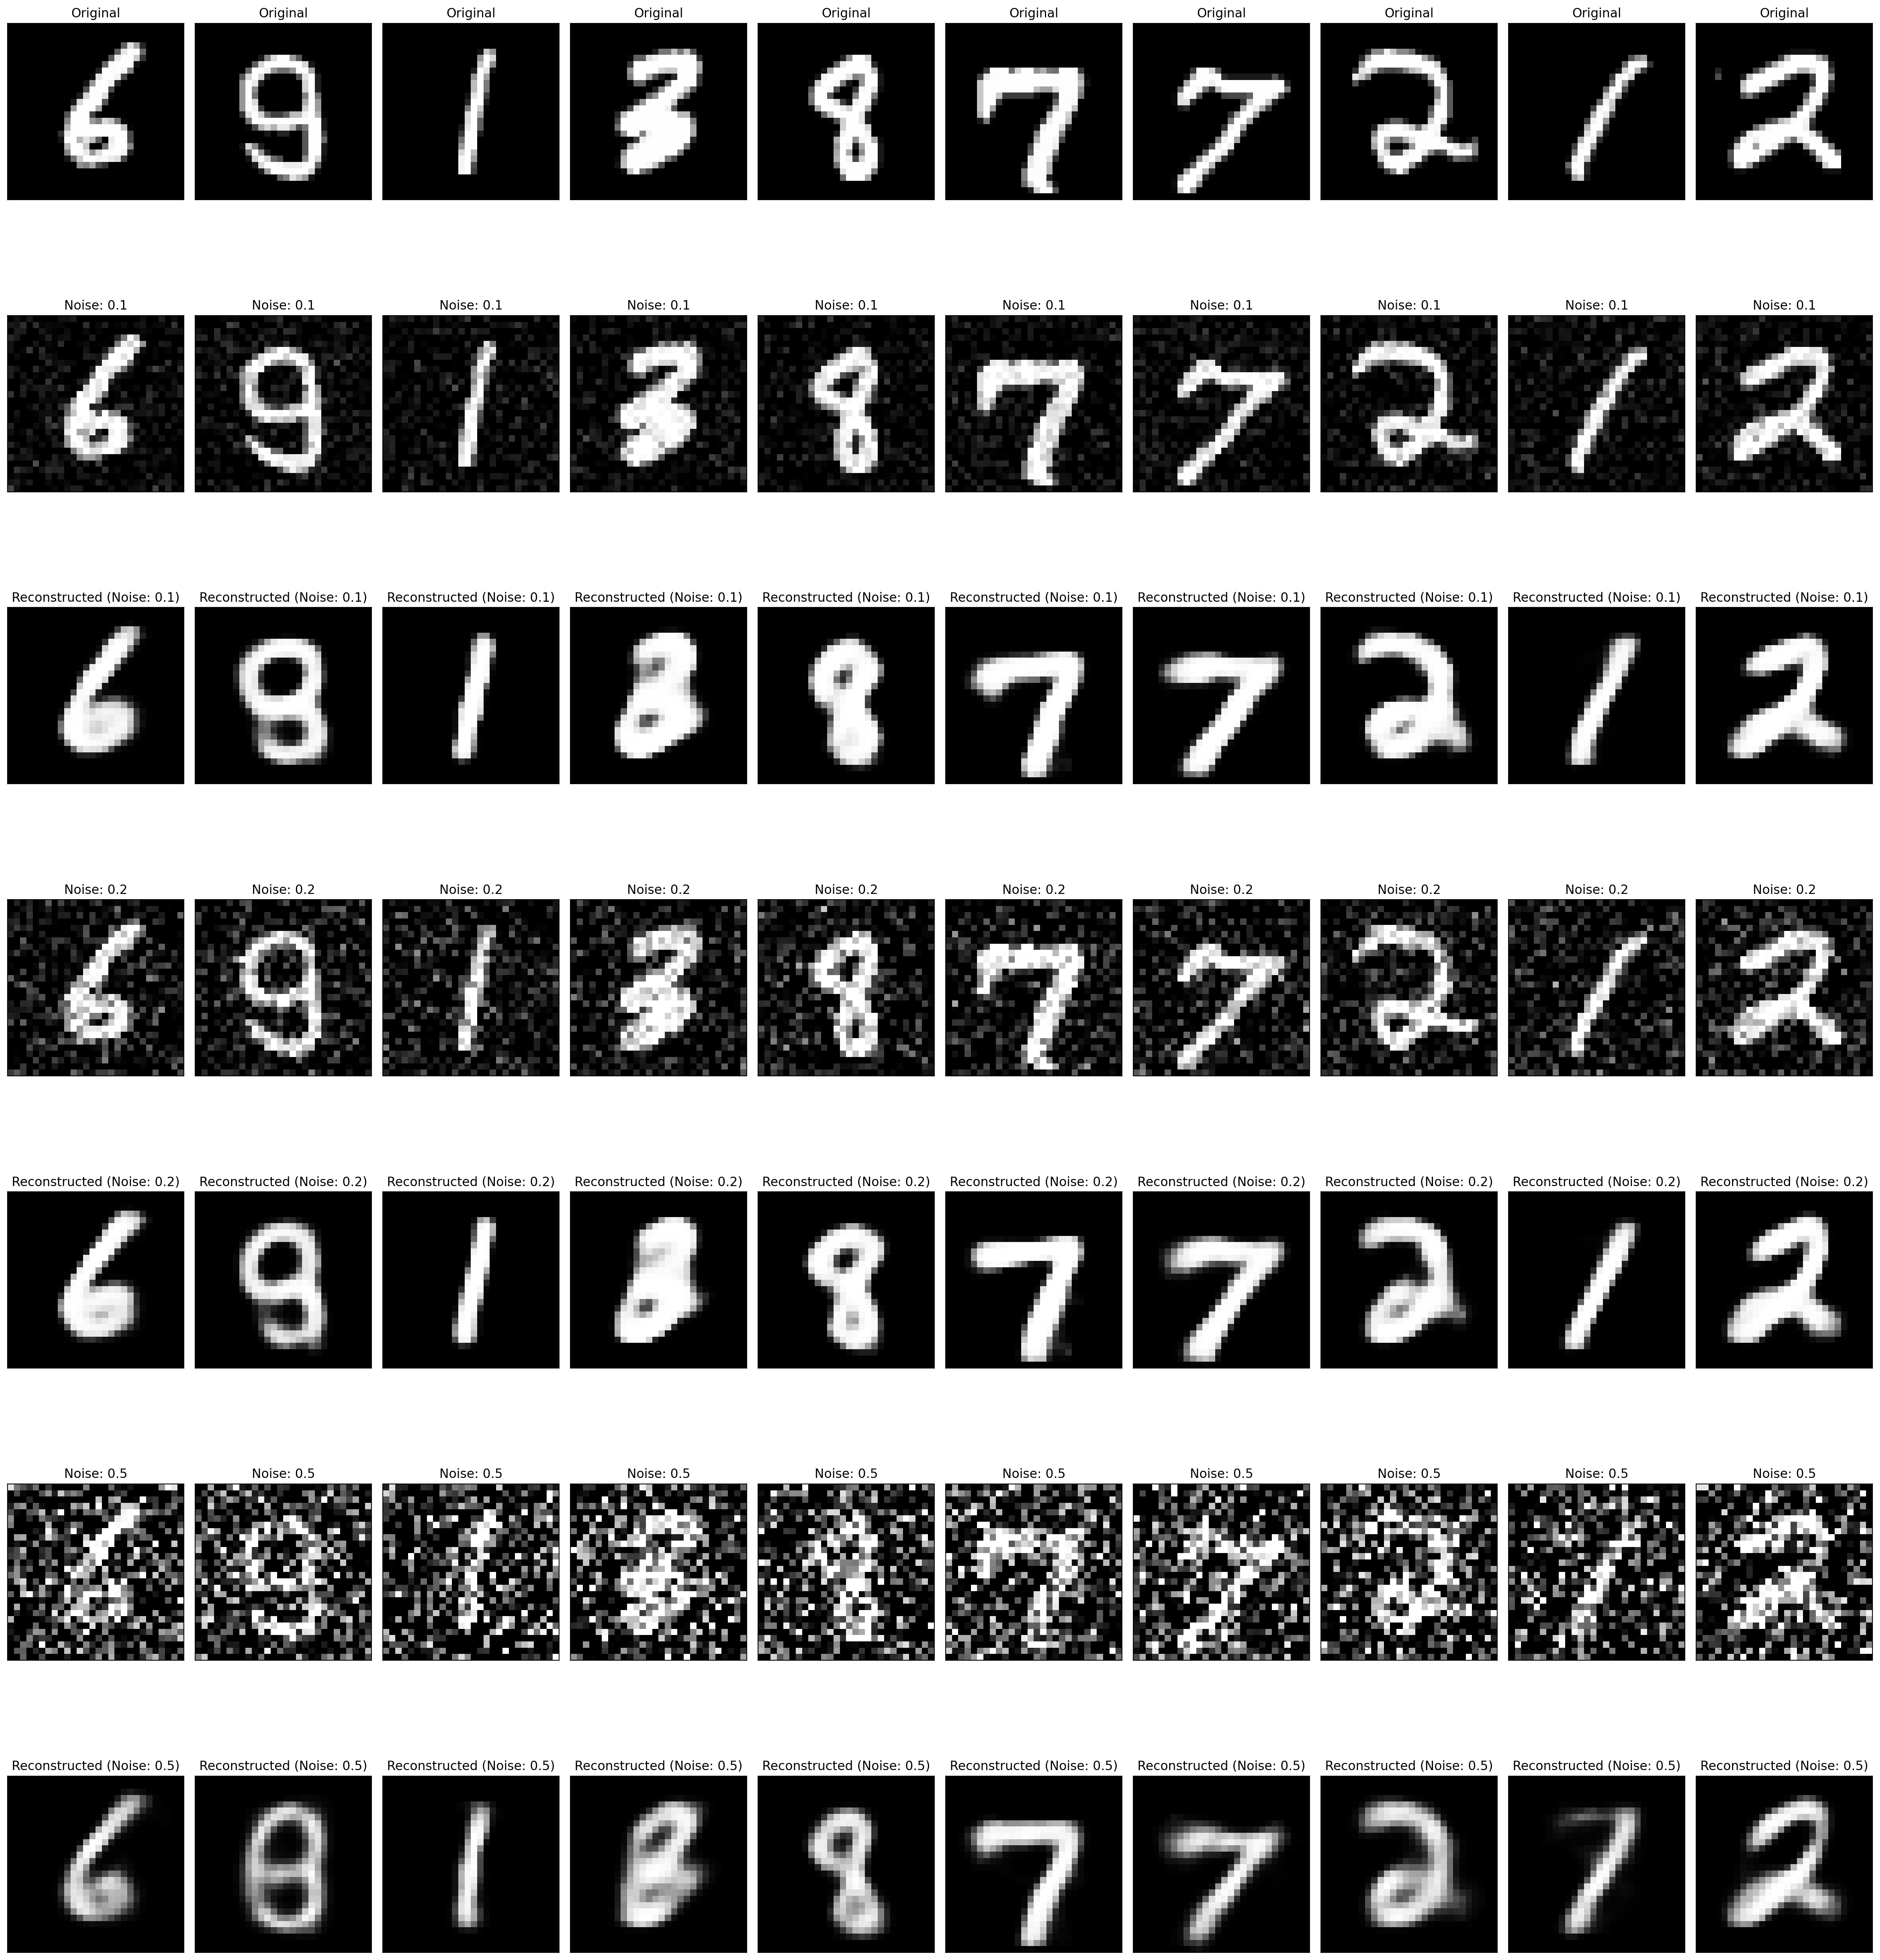

In [20]:
model.cpu()
# Define variance values
variance_values = [0.1, 0.2, 0.5]

# Obtain one batch of test images
dataiter = iter(testloader_mnist)
images, _ = next(dataiter)
images_flatten = images.view(images.size(0), -1)

# Plot the images
fig, axes = plt.subplots(nrows=len(variance_values)*2+1, ncols=10, figsize=(25, 4*(len(variance_values)*2+1)))

# Plot original images
for col, img in enumerate(images[:10]):
    axes[0, col].imshow(np.squeeze(img), cmap='gray')
    axes[0, col].get_xaxis().set_visible(False)
    axes[0, col].get_yaxis().set_visible(False)
    axes[0, col].set_title('Original')

row_counter = 1
for variance in variance_values:
    # Add noise
    noisy_images = add_gaussian_noise(images, variance)
    
    # Plot noisy images
    for col, img in enumerate(noisy_images[:10]):
        axes[row_counter, col].imshow(np.squeeze(img), cmap='gray')
        axes[row_counter, col].get_xaxis().set_visible(False)
        axes[row_counter, col].get_yaxis().set_visible(False)
        axes[row_counter, col].set_title(f'Noise: {variance}')

    row_counter += 1

    # Get reconstructed images
    output = model(noisy_images.view(noisy_images.size(0), -1))
    output = output.view(batch_size, 1, 28, 28).detach().numpy()
    
    # Plot reconstructed images
    for col, img in enumerate(output[:10]):
        axes[row_counter, col].imshow(np.squeeze(img), cmap='gray')
        axes[row_counter, col].get_xaxis().set_visible(False)
        axes[row_counter, col].get_yaxis().set_visible(False)
        axes[row_counter, col].set_title(f'Reconstructed (Noise: {variance})')

    row_counter += 1

plt.tight_layout()
plt.show()

FMINST database

In [12]:
model = Denoising_Autoencoder(epochs=20, lr=0.01, noise_level=0.5)
to_device(model, device)

model.trainloop(trainloader_fmnist, validloader_fmnist)

Epoch 0. Training PSNR: 13.599943, Validation PSNR: 14.684870
Epoch 1. Training PSNR: 14.381351, Validation PSNR: 14.962253
Epoch 2. Training PSNR: 14.434416, Validation PSNR: 14.944102
Epoch 3. Training PSNR: 14.493624, Validation PSNR: 14.795115
Epoch 4. Training PSNR: 14.476615, Validation PSNR: 14.775221
Epoch 5. Training PSNR: 14.483027, Validation PSNR: 14.974971
Epoch 6. Training PSNR: 14.496630, Validation PSNR: 15.034692
Epoch 7. Training PSNR: 14.529299, Validation PSNR: 15.089795
Epoch 8. Training PSNR: 14.527076, Validation PSNR: 14.877398
Epoch 9. Training PSNR: 14.527814, Validation PSNR: 14.912760
Epoch 10. Training PSNR: 14.469037, Validation PSNR: 14.864572
Epoch 11. Training PSNR: 14.515219, Validation PSNR: 14.630819
Epoch 12. Training PSNR: 14.524434, Validation PSNR: 14.978018
Epoch 13. Training PSNR: 14.459391, Validation PSNR: 14.891079
Epoch 14. Training PSNR: 14.435245, Validation PSNR: 14.821796
Epoch 15. Training PSNR: 14.462975, Validation PSNR: 15.067060
Ep

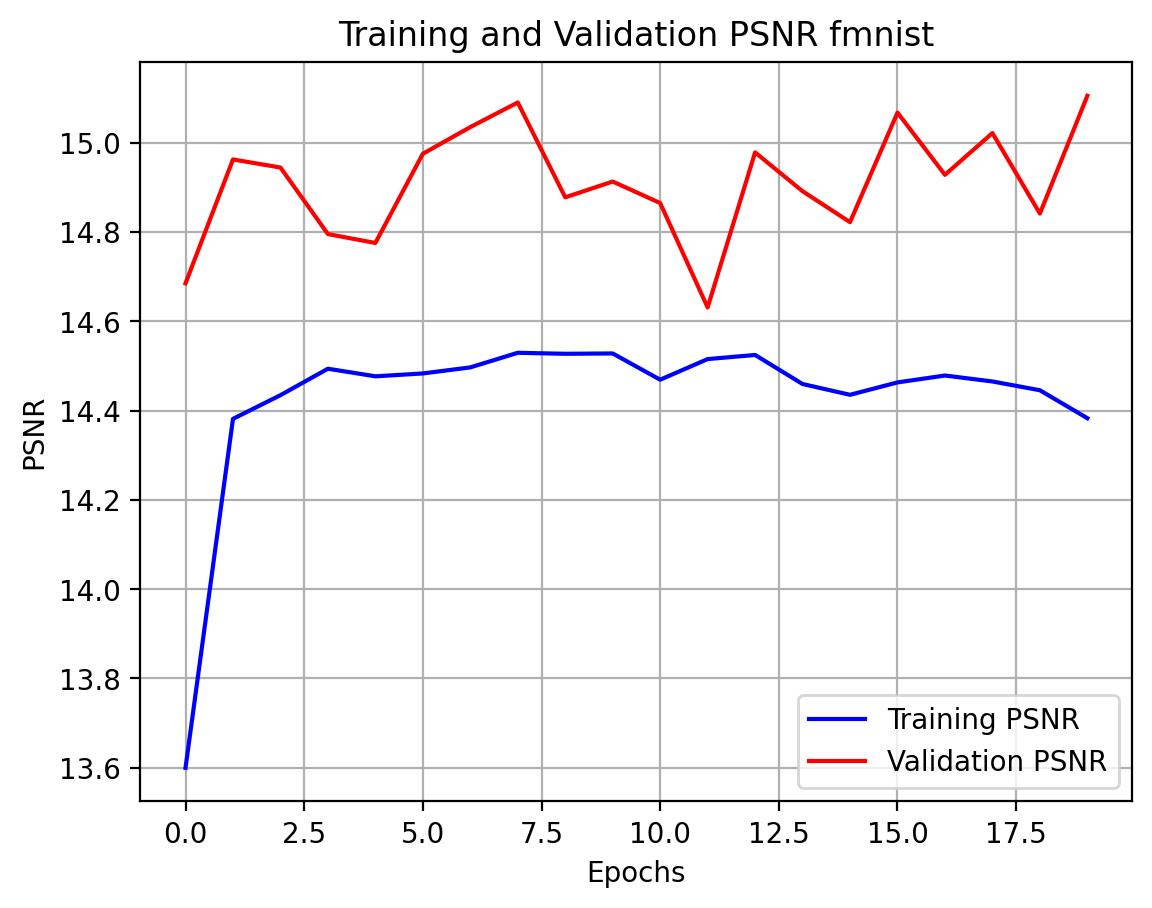

In [13]:
plt.plot(model.PSNR_during_training, color = "blue", label="Training PSNR")
plt.plot(model.valid_PSNR_during_training, color = "red", label="Validation PSNR")
plt.title("Training and Validation PSNR fmnist")
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()

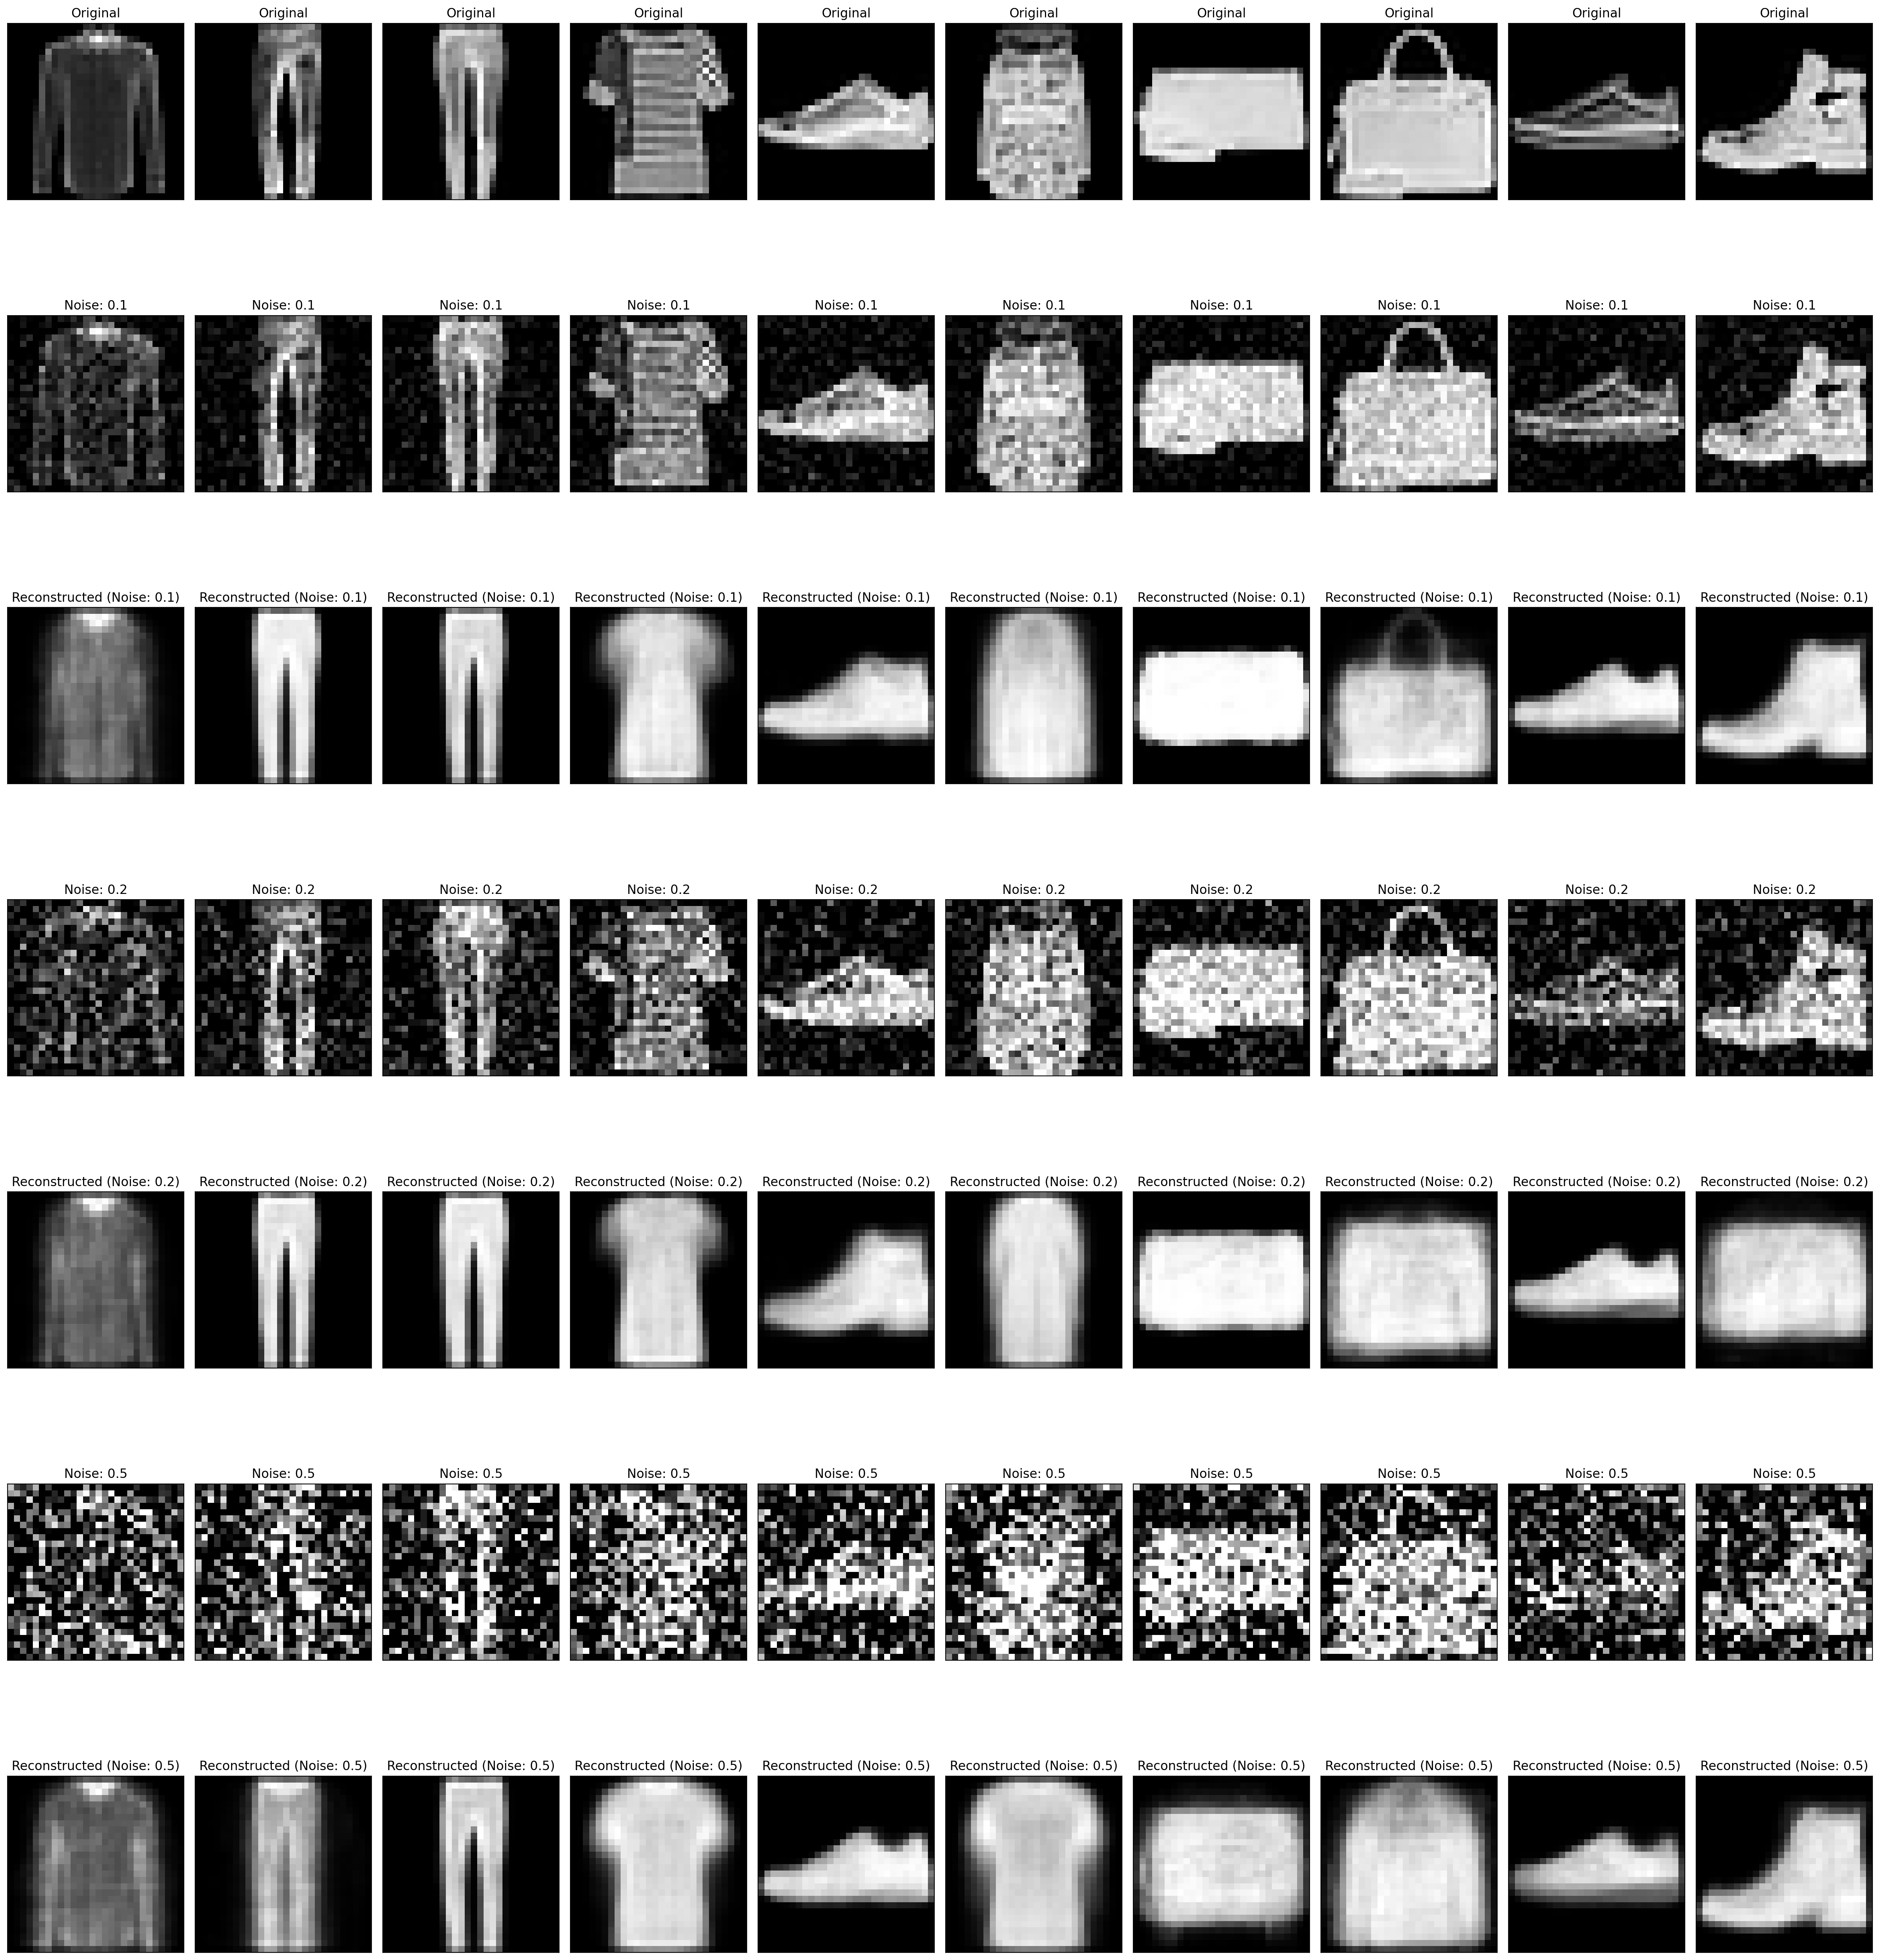

In [14]:
model.cpu()
# Define variance values
variance_values = [0.1, 0.2, 0.5]

# Obtain one batch of test images
dataiter = iter(testloader_fmnist)
images, _ = next(dataiter)
images_flatten = images.view(images.size(0), -1)

# Plot the images
fig, axes = plt.subplots(nrows=len(variance_values)*2+1, ncols=10, figsize=(25, 4*(len(variance_values)*2+1)))

# Plot original images
for col, img in enumerate(images[:10]):
    axes[0, col].imshow(np.squeeze(img), cmap='gray')
    axes[0, col].get_xaxis().set_visible(False)
    axes[0, col].get_yaxis().set_visible(False)
    axes[0, col].set_title('Original')

row_counter = 1
for variance in variance_values:
    # Add noise
    noisy_images = add_gaussian_noise(images, variance)
    
    # Plot noisy images
    for col, img in enumerate(noisy_images[:10]):
        axes[row_counter, col].imshow(np.squeeze(img), cmap='gray')
        axes[row_counter, col].get_xaxis().set_visible(False)
        axes[row_counter, col].get_yaxis().set_visible(False)
        axes[row_counter, col].set_title(f'Noise: {variance}')

    row_counter += 1

    # Get reconstructed images
    output = model(noisy_images.view(noisy_images.size(0), -1))
    output = output.view(batch_size, 1, 28, 28).detach().numpy()
    
    # Plot reconstructed images
    for col, img in enumerate(output[:10]):
        axes[row_counter, col].imshow(np.squeeze(img), cmap='gray')
        axes[row_counter, col].get_xaxis().set_visible(False)
        axes[row_counter, col].get_yaxis().set_visible(False)
        axes[row_counter, col].set_title(f'Reconstructed (Noise: {variance})')

    row_counter += 1

plt.tight_layout()
plt.show()